In [1]:
# all codes come are changed based on LDR code.
import argparse
import torch.optim as optim
import os
import yaml
from mcrgan.default import _C as config
from mcrgan.default import update_config
import torch
from mcrgan.trainer import MCRTrainer
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.models import get_BNN_models
from mcrgan.models import get_noise
from mcrgan.models import DiscriminatorMNIST
from mcrgan.models import weights_init_mnist_model_noise

import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os
from mcrgan.loss import MCRGANloss
import random
#random.seed(0)

In [2]:
# data_preprocessing and parameters

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
DATASET = 'FMNIST'
ROOT    = 'pth/to/the/dataset'
BATCH_SIZE = 2048
WORKERS = 0
DATA_SAMPLE = 50000
LABEL = 3

dataloader, dataset = get_dataloader(
        data_name=DATASET,
        root=ROOT,
        batch_size=BATCH_SIZE,
        num_workers=WORKERS)


In [3]:
import collections

def get_netG(netD,netV,net_noise,radius=1):
    models = [netD, netV,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    fed_state_dict = collections.OrderedDict()
    for key in weight_keys:
        fed_state_dict[key] = worker_state_dict[0][key] + radius*worker_state_dict[2][key]*torch.log(1+torch.exp(worker_state_dict[1][key]))
    return fed_state_dict

# new netG already optimized by adam and time learning rate, so we only using netG to update netV
def update_netV(netV,netG,net_noise,fed_state_dict,radius=1):
    models =[netV,netG,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    update_dict = collections.OrderedDict()
    for key in weight_keys:
        update_dict[key] = worker_state_dict[0][key] - (worker_state_dict[1][key]-fed_state_dict[key])*(worker_state_dict[2][key]*radius)/torch.log(1+torch.exp(-worker_state_dict[0][key]))
    return update_dict
        

In [4]:
#models
# train hyperparameters, batch norm not used var
#store_Var = []
import time
from torch_mimicry.training import scheduler, logger, metric_log

from test_acc import nearsub
import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features2
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os

start_time = time.time()
#global_step = 0
num_steps = 500
n_dis = 1
n_dis2 = 1
numclasses =10
lr1 = 1e-3
lr2 = 1e-3
log_data = metric_log.MetricLog()
data_time = time.time()
iter_dataloader = iter(dataloader)
data, label = next(iter_dataloader)
data_time = time.time() - data_time
real_cpu = data.to(device)
real_label = label.clone().detach()

netD, netG, netV = get_BNN_models(DATASET, device, LABEL)
net_noise = get_noise(DATASET, device, LABEL)
fed_state_dict = get_netG(netD,netV,net_noise)
netG.load_state_dict(fed_state_dict)
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))

Acc_results_D = []
Acc_results_G = []




transform = transforms.Compose(
            [transforms.Resize(32),
             transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)])

trainset = datasets.FashionMNIST(root=ROOT, train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=ROOT, train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
        testset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)

trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
n_comp = 10


In [5]:
netD, netG, netV

(DataParallel(
   (module): DiscriminatorMNIST_nz11(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): LeakyReLU(negative_slope=0.2, inplace=True)
       (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (5): LeakyReLU(negative_slope=0.2, inplace=True)
       (6): Conv2d(256, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (7): Flatten(start_dim=1, end_dim=-1)
     )
   )
 ),
 DataParallel(
   (module): DiscriminatorMNIST_nz11(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): LeakyReLU(negative_s

In [6]:
net_noise

DataParallel(
  (module): DiscriminatorMNIST_nz11(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(256, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (7): Flatten(start_dim=1, end_dim=-1)
    )
  )
)

In [7]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=11, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
         
    return radius1,radius2

In [8]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius_val(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=11, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    n_comp = 10
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
            
    fed_state_dict = get_netG(netD,netV,net_noise,radius1)
    netG.load_state_dict(fed_state_dict)
    Z_bar = netG(real_cpu)
    
    
    corr_mean = np.zeros([n_comp,n_comp])
    corr_abs_mean = np.zeros([n_comp,n_comp])
    corr_min  = np.zeros([n_comp,n_comp])
    corr_max  = np.zeros([n_comp,n_comp])

    for i in range(10):
        for j in range(10):
            if i >= j :
                # change to 150 fit FMNIST data
                similarity_matrix = torch.nn.functional.cosine_similarity(Z_bar[label==i][0:150], Z_bar[label==j][0:150])
                temp_mean = torch.mean(similarity_matrix)
                temp_min = torch.min(similarity_matrix)
                temp_max = torch.max(similarity_matrix)
                temp_abs_mean = torch.mean(abs(similarity_matrix))

                corr_mean[i][j] = temp_mean
                corr_abs_mean[i][j] = temp_abs_mean
                corr_min[i][j]  = temp_min
                corr_max[i][j]  = temp_max

                corr_mean[j][i] = corr_mean[i][j]
                corr_abs_mean[j][i] = corr_abs_mean[i][j]
                corr_min[j][i] = corr_min[i][j]
                corr_max[j][i] = corr_max[i][j]
                
    corr_whole = np.zeros([4*n_comp,n_comp])
    corr_whole[0:10][:] =  corr_mean
    corr_whole[10:20][:] = corr_abs_mean
    corr_whole[20:30][:] = corr_min
    corr_whole[30:40][:] = corr_max
    
    
    fed_state_dict = get_netG(netD,netV,net_noise,radius1)
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    acc_val = count/10000
    print('NetG_fixDwith radius',radius1,acc_val)

         
    return radius1,radius2,corr_whole,acc_val

In [9]:
# fixed radius case, due to this requires more steps to go to about -200 then set 1500 epoches
mean_V = []
n_dis2 = 1
n_dis = 1
mode = 1
gam3 = 1
mcr_gan_loss = MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=mode, rho=None)
loss_V = 0
last_V = -1000
num_steps = 500
lr1 = 1e-3
lr2 = 1e-3
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
meanV_sum = []
radius_list = []
radius = 0
for epoch in range(num_steps):

    for i in range(n_dis):
        netD.zero_grad()
        optD.zero_grad()
        Z = netD(real_cpu)
        net_noise = get_noise(DATASET, device, LABEL)
        #radius,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
        #radius_list.append(radius)
        #print(radius)
        fed_state_dict = get_netG(netD,netV,net_noise,radius)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errD, errD_EC = mcr_gan_loss(Z, Z_bar, real_label, 1, n_dis)
        print(errD, errD_EC)
        errD.backward()
        optD.step()

    #print(meanV_num)
    #print(tempV)
    
    

tensor(-1.0099, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-0.5049, device='cuda:0', grad_fn=<NegBackward0>), tensor(-0.5049, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-1.5633, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-0.7816, device='cuda:0', grad_fn=<NegBackward0>), tensor(-0.7816, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-2.5318, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-1.2659, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.2659, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-2.6026, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-1.3013, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.3013, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-2.3476, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-

tensor(-6.3475, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.1737, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.1737, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-6.3240, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.1620, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.1620, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-6.2934, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.1467, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.1467, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-6.3379, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.1689, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.1689, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-6.2500, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-

tensor(-6.9525, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.4763, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.4763, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-6.9757, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.4878, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.4878, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.1200, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.5600, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.5600, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.1153, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.5577, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.5577, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.1479, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.5739, 

tensor(-7.6353, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.8176, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.8176, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.5691, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.7846, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.7846, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.5218, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.7609, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.7609, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.5350, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.7675, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.7675, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.6140, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.8070, d

tensor(-7.8407, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9204, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.9204, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.8479, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9240, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.9240, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.8727, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9364, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.9364, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.8213, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9106, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.9106, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.7592, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.8796, de

tensor(-7.8726, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9363, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.9363, device='cuda:0', grad_fn=<NegBackward0>), tensor(-5.7220e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.7811, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.8906, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.8906, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.0335, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.0168, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.0168, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.9856, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9928, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.9928, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.8723, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.9362, d

tensor(-8.1993, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.0997, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.0997, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.3651, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.1826, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.1826, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.3082, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.1541, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.1541, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.2603, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.1301, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.1301, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.3403, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4

tensor(-8.4714, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2357, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2357, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.4842, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2421, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2421, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.4242, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2121, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2121, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.3981, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.1991, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.1991, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.3560, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.1780, device='cuda:0', g

tensor(-8.5106, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2553, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2553, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5486, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2743, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2743, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5712, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2856, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2856, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5837, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2919, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2919, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5786, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-

tensor(-8.5893, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2947, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2947, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5961, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2981, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2981, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5955, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2978, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2978, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5949, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2974, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2974, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5858, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2929, device='c

tensor(-8.5914, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2957, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2957, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5894, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2947, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2947, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5880, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2940, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2940, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5841, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2921, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2921, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5790, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2895, de

tensor(-8.5990, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2995, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2995, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5992, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2996, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2996, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5967, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2983, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2983, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5970, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2985, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2985, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5939, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-

tensor(-8.5974, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2987, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2987, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5996, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2998, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2998, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5989, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2994, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2994, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.9073e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5977, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2989, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2989, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5967, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2983, d

tensor(-8.5989, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2995, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2995, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5975, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2988, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2988, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.8147e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5986, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2993, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2993, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5973, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2987, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2987, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.5972, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2986, device='cu

In [10]:
#10/256, 9/1000 for 200 epoches -196.2230, resample again under load case to avoid wrong.
r_records = np.zeros(1000)
for i in range(1000):
    radius_bar,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
    r_records[i] = radius_bar
    print(radius_bar)

99.97201769495192
17.576041630573414
0.0002273920307131766
99.98839657605964
99.97201769495192
8.458435541508441
2.83270777715625e-05
15.090421262833788
99.98211036263734
17.657838745995814
99.98025764220189
9.15922966939729
7.6347892382401605
0.03202569783066672
99.75473014461821
13.210652891649097
29.651176029818775
11.469160013376461
0.0013059726208975654
0.03796595272946666
0.010243782718886593
42.36388547334396
10.196896747067349
68.14043745800896
8.921283942745658
13.358906568671982
0.001901351570342927
0.0003649133914264361
8.920768490527337
18.160912731739963
93.45279242875519
10.28956861543784
99.98919885342524
8.11641032000348
0.010318051750843044
59.41531534392854
99.96793596386014
6.376234186416169
0.0027007801040778863
22.6922112842058
16.05105569260807
11.527573304445287
2.049828917622279e-05
9.007854806762092
4.5836695423240294e-05
0.0007407520161100443
7.685238860892799
9.851928854937684
8.750814082303846
0.010379551660332128
99.9888562089947
2.83270777715625e-05
6.3507

31.85674417130172
13.177346032041754
10.133136586668174
8.80373595721252
0.00016102500628698853
0.012533848275602598
4.5836695423240294e-05
98.8875984256912
8.507663752647101
99.89087774685561
0.004342291875195303
99.99338824107328
0.006149080057788642
99.98921935364012
0.006376495973565132
99.87143870690727
8.877395161863236
99.96949314545007
0.012618053008077654
99.9770600028561
21.16100181209296
99.97860140430394
0.00023223022206509655
0.00024786487989306844
14.897669995597727
17.73792482721457
99.90773908930365
99.9493945831387
6.6063520448700075
99.99495045294758
0.0036801121700577592
99.9835824272289
11.63732205163073
0.00016585251749000993
99.99182437273511
8.367838831297725
0.0003268988842665162
21.91208456693568
19.859225874485166
12.213756078063565
8.250377767628477
8.173901385593627
99.98907396892923
9.933670410808931
20.573643980409788
9.624019911151947
0.016422603612258148
99.97825093731794
11.308802681715477
7.6668582104645635
99.97995053415953
0.0016123970990445484
11.47

0.0004342863706034267
8.366279804267002
0.00028887057940273954
99.99182921188923
99.93972156211515
99.99121332612457
37.89148490930778
30.211897923984512
38.175480837857435
0.00010435260800092488
0.033281086072396965
99.97201769495192
99.9871309745951
6.354772201851421
20.697774340753313
10.024593811425637
8.071265067289199
99.98908364627471
99.96118503124444
20.166487359260344
18.06660773404907
6.840542102027538
9.75883819424705
13.77738790083697
2.049828917622279e-05
40.17825256779447
0.0006411597141045043
0.0029187851622477154
16.464984924219657
5.824932072461111
6.149583048389711e-05
10.703516896192982
99.98932185924912
9.845128588294846
7.416941006996812e-05
0.016160750056644253
0.0013283204299011633
7.143062071920193
36.43990509497087
99.96131860472451
8.22458307097262
50.150345709082124
4.848549471353908
15.298402039256835
99.94394809224255
0.007051196777667834
26.9303502902603
25.519650465717806
91.98955845959838
30.300526929070312
0.008863204481543688
12.848315007069372
0.0061

In [11]:
np.histogram(r_records)

(array([458, 180,  64,  19,  17,   6,   5,   5,   4, 242], dtype=int64),
 array([ 0.        ,  9.99969644, 19.99939288, 29.99908932, 39.99878575,
        49.99848219, 59.99817863, 69.99787507, 79.99757151, 89.99726795,
        99.99696439]))

In [12]:
#acc at first for NetD
NetD_acc = 0
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(testloader, netD, netG)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netD, netG)


print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

#acc at first for NetD
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
        
NetD_acc = count/10000
print('NetD, Acc at first', NetD_acc)
Acc_results_D.append(count/10000)

#acc at first for NetG
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)


#acc at first
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
print('NetG, Acc at first',count/10000)
Acc_results_G.append(count/10000)


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.38549999999999995
SVD: 0.31399999999999995
NetD, Acc at first 0.8381


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.4245
SVD: 0.2773
NetG, Acc at first 0.8197


In [13]:
#robust testing
r_list = [0,0.1,0.2,0.5,1,2,3,4,6,8,10]
sample_num = 20
acc_record = np.zeros([4,20])


In [14]:
# sample 20 times of NetG at final radius, NetD is fixed, length 0.1,0.2,0.5,1,2,4,6,8,10,15,20
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample = []
for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[1])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample.append(count/10000)

print(max(Acc_results_G_sample),min(Acc_results_G_sample),np.mean(Acc_results_G_sample),np.var(Acc_results_G_sample))


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.4276
SVD: 0.2713
NetG_fixD, Acc at sample 1 0.8208


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.42369999999999997
SVD: 0.2802
NetG_fixD, Acc at sample 2 0.8203


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.4204
SVD: 0.27780000000000005
NetG_fixD, Acc at sample 3 0.8215


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.4202
SVD: 0.27990000000000004
NetG_fixD, Acc at sample 4 0.8211


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.42469999999999997
SVD: 0.2885
NetG_fixD, Acc at sample 5 0.8218


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.42789999999999995
SVD: 0.28300000000000003
NetG_fixD, Acc at sample 6 0.8205


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.4295
SVD: 0.27869999999999995
NetG_fixD, Acc at sample 7 0.8207


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.42710000000000004
SVD: 0.279
NetG_fixD, Acc at sample 8 0.8205


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.41890000000000005
SVD: 0.2724
NetG_fixD, Acc at sample 9 0.8183


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.4203
SVD: 0.28059999999999996
NetG_fixD, Acc at sample 10 0.821


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.42710000000000004
SVD: 0.2744
NetG_fixD, Acc at sample 11 0.8196


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.4285
SVD: 0.2771
NetG_fixD, Acc at sample 12 0.8212


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.4216
SVD: 0.27349999999999997
NetG_fixD, Acc at sample 13 0.8199


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.4244
SVD: 0.2812
NetG_fixD, Acc at sample 14 0.8195


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.41559999999999997
SVD: 0.26780000000000004
NetG_fixD, Acc at sample 15 0.8192


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.42390000000000005
SVD: 0.27490000000000003
NetG_fixD, Acc at sample 16 0.8207


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.42310000000000003
SVD: 0.275
NetG_fixD, Acc at sample 17 0.8181


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.4252
SVD: 0.27070000000000005
NetG_fixD, Acc at sample 18 0.8203


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.4206
SVD: 0.2804
NetG_fixD, Acc at sample 19 0.8189


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.41769999999999996
SVD: 0.2794
NetG_fixD, Acc at sample 20 0.8205
0.8218 0.8181 0.82022 9.745999999999866e-07


In [15]:
acc_record[0][0] = NetD_acc
acc_record[1][0] = NetD_acc
acc_record[2][0] = NetD_acc
acc_record[3][0] = 0
acc_record[0][1] = np.mean(Acc_results_G_sample)
acc_record[1][1] = max(Acc_results_G_sample)
acc_record[2][1] = min(Acc_results_G_sample)
acc_record[3][1] = np.var(Acc_results_G_sample)

In [16]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample2 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[2])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample2.append(count/10000)
    
print(max(Acc_results_G_sample2),min(Acc_results_G_sample2),np.mean(Acc_results_G_sample2),np.var(Acc_results_G_sample2))
acc_record[0][2] = np.mean(Acc_results_G_sample2)
acc_record[1][2] = max(Acc_results_G_sample2)
acc_record[2][2] = min(Acc_results_G_sample2)
acc_record[3][2] = np.var(Acc_results_G_sample2)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.4273
SVD: 0.28090000000000004
NetG_fixD, Acc at sample 1 0.8205


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.4233
SVD: 0.278
NetG_fixD, Acc at sample 2 0.8193


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.4306
SVD: 0.267
NetG_fixD, Acc at sample 3 0.8206


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.4154
SVD: 0.2761
NetG_fixD, Acc at sample 4 0.8211


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.43000000000000005
SVD: 0.2781
NetG_fixD, Acc at sample 5 0.8195


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.4242
SVD: 0.2704
NetG_fixD, Acc at sample 6 0.8184


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.4366
SVD: 0.27459999999999996
NetG_fixD, Acc at sample 7 0.8219


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.4245
SVD: 0.2862
NetG_fixD, Acc at sample 8 0.8207


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.4021
SVD: 0.27869999999999995
NetG_fixD, Acc at sample 9 0.821


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.4345
SVD: 0.27359999999999995
NetG_fixD, Acc at sample 10 0.8187


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.45109999999999995
SVD: 0.28359999999999996
NetG_fixD, Acc at sample 11 0.8209


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.4185
SVD: 0.2821
NetG_fixD, Acc at sample 12 0.8202


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.4193
SVD: 0.27349999999999997
NetG_fixD, Acc at sample 13 0.8217


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.4155
SVD: 0.2922
NetG_fixD, Acc at sample 14 0.8176


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.4154
SVD: 0.2833
NetG_fixD, Acc at sample 15 0.8203


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.42479999999999996
SVD: 0.27449999999999997
NetG_fixD, Acc at sample 16 0.8187


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.4173
SVD: 0.28069999999999995
NetG_fixD, Acc at sample 17 0.8201


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.4115
SVD: 0.27559999999999996
NetG_fixD, Acc at sample 18 0.8203


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.4256
SVD: 0.27080000000000004
NetG_fixD, Acc at sample 19 0.8212


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.42500000000000004
SVD: 0.27990000000000004
NetG_fixD, Acc at sample 20 0.8217
0.8219 0.8176 0.82022 1.3325999999999921e-06


In [17]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample3 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[3])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample3.append(count/10000)
    
print(max(Acc_results_G_sample3),min(Acc_results_G_sample3),np.mean(Acc_results_G_sample3),np.var(Acc_results_G_sample3))
acc_record[0][3] = np.mean(Acc_results_G_sample3)
acc_record[1][3] = max(Acc_results_G_sample3)
acc_record[2][3] = min(Acc_results_G_sample3)
acc_record[3][3] = np.var(Acc_results_G_sample3)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.47330000000000005
SVD: 0.28969999999999996
NetG_fixD, Acc at sample 1 0.8204


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.3889
SVD: 0.29179999999999995
NetG_fixD, Acc at sample 2 0.8215


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.38759999999999994
SVD: 0.2851
NetG_fixD, Acc at sample 3 0.819


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.37870000000000004
SVD: 0.26049999999999995
NetG_fixD, Acc at sample 4 0.8202


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.4292
SVD: 0.28690000000000004
NetG_fixD, Acc at sample 5 0.8213


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.3983
SVD: 0.2993
NetG_fixD, Acc at sample 6 0.8215


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.4252
SVD: 0.267
NetG_fixD, Acc at sample 7 0.8219


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.42810000000000004
SVD: 0.2662
NetG_fixD, Acc at sample 8 0.8219


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.4171
SVD: 0.2792
NetG_fixD, Acc at sample 9 0.8209


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.4253
SVD: 0.2851
NetG_fixD, Acc at sample 10 0.8207


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.42910000000000004
SVD: 0.2631
NetG_fixD, Acc at sample 11 0.8216


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.4071
SVD: 0.28280000000000005
NetG_fixD, Acc at sample 12 0.8235


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.35850000000000004
SVD: 0.264
NetG_fixD, Acc at sample 13 0.8233


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.36719999999999997
SVD: 0.28190000000000004
NetG_fixD, Acc at sample 14 0.8189


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.37070000000000003
SVD: 0.27849999999999997
NetG_fixD, Acc at sample 15 0.8216


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.42979999999999996
SVD: 0.2701
NetG_fixD, Acc at sample 16 0.8219


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.42769999999999997
SVD: 0.29490000000000005
NetG_fixD, Acc at sample 17 0.8239


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.4131
SVD: 0.26060000000000005
NetG_fixD, Acc at sample 18 0.8236


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.40780000000000005
SVD: 0.29669999999999996
NetG_fixD, Acc at sample 19 0.8196


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.44320000000000004
SVD: 0.28180000000000005
NetG_fixD, Acc at sample 20 0.823
0.8239 0.8189 0.82151 2.035900000000007e-06


In [18]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample4 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[4])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample4.append(count/10000)
    
print(max(Acc_results_G_sample4),min(Acc_results_G_sample4),np.mean(Acc_results_G_sample4),np.var(Acc_results_G_sample4))
acc_record[0][4] = np.mean(Acc_results_G_sample4)
acc_record[1][4] = max(Acc_results_G_sample4)
acc_record[2][4] = min(Acc_results_G_sample4)
acc_record[3][4] = np.var(Acc_results_G_sample4)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.40700000000000003
SVD: 0.2843
NetG_fixD, Acc at sample 1 0.8211


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.35629999999999995
SVD: 0.25539999999999996
NetG_fixD, Acc at sample 2 0.8187


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.3244
SVD: 0.24
NetG_fixD, Acc at sample 3 0.82


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.2975
SVD: 0.23919999999999997
NetG_fixD, Acc at sample 4 0.8202


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.4153
SVD: 0.2649
NetG_fixD, Acc at sample 5 0.8181


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.4444
SVD: 0.29679999999999995
NetG_fixD, Acc at sample 6 0.8193


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.34309999999999996
SVD: 0.22799999999999998
NetG_fixD, Acc at sample 7 0.8232


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.38939999999999997
SVD: 0.23950000000000005
NetG_fixD, Acc at sample 8 0.8187


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.3315
SVD: 0.2259
NetG_fixD, Acc at sample 9 0.8234


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.32210000000000005
SVD: 0.19279999999999997
NetG_fixD, Acc at sample 10 0.8175


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.33940000000000003
SVD: 0.2601
NetG_fixD, Acc at sample 11 0.8206


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.33720000000000006
SVD: 0.25260000000000005
NetG_fixD, Acc at sample 12 0.8179


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.35409999999999997
SVD: 0.27880000000000005
NetG_fixD, Acc at sample 13 0.8208


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.3689
SVD: 0.25939999999999996
NetG_fixD, Acc at sample 14 0.821


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.40759999999999996
SVD: 0.24919999999999998
NetG_fixD, Acc at sample 15 0.821


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.4333
SVD: 0.28369999999999995
NetG_fixD, Acc at sample 16 0.8213


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.3752
SVD: 0.28979999999999995
NetG_fixD, Acc at sample 17 0.8179


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.39370000000000005
SVD: 0.2955
NetG_fixD, Acc at sample 18 0.8194


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.4
SVD: 0.2712
NetG_fixD, Acc at sample 19 0.8189


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.38649999999999995
SVD: 0.29259999999999997
NetG_fixD, Acc at sample 20 0.8197
0.8234 0.8175 0.8199349999999999 2.593275000000031e-06


In [19]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample5 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[5])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample5.append(count/10000)
    
print(max(Acc_results_G_sample5),min(Acc_results_G_sample5),np.mean(Acc_results_G_sample5),np.var(Acc_results_G_sample5))
acc_record[0][5] = np.mean(Acc_results_G_sample5)
acc_record[1][5] = max(Acc_results_G_sample5)
acc_record[2][5] = min(Acc_results_G_sample5)
acc_record[3][5] = np.var(Acc_results_G_sample5)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.34609999999999996
SVD: 0.2419
NetG_fixD, Acc at sample 1 0.8009


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.28680000000000005
SVD: 0.22199999999999998
NetG_fixD, Acc at sample 2 0.8057


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.32010000000000005
SVD: 0.2694
NetG_fixD, Acc at sample 3 0.8161


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.33120000000000005
SVD: 0.2672
NetG_fixD, Acc at sample 4 0.8119


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.31200000000000006
SVD: 0.23470000000000002
NetG_fixD, Acc at sample 5 0.8113


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.3407
SVD: 0.2309
NetG_fixD, Acc at sample 6 0.8136


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.34619999999999995
SVD: 0.2862
NetG_fixD, Acc at sample 7 0.8104


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.3025
SVD: 0.24370000000000003
NetG_fixD, Acc at sample 8 0.8136


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.23660000000000003
SVD: 0.23460000000000003
NetG_fixD, Acc at sample 9 0.8068


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.30300000000000005
SVD: 0.2309
NetG_fixD, Acc at sample 10 0.8097


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.35860000000000003
SVD: 0.2573
NetG_fixD, Acc at sample 11 0.8091


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.34550000000000003
SVD: 0.21909999999999996
NetG_fixD, Acc at sample 12 0.8114


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.28369999999999995
SVD: 0.23370000000000002
NetG_fixD, Acc at sample 13 0.8105


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.26890000000000003
SVD: 0.2148
NetG_fixD, Acc at sample 14 0.8096


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.2593
SVD: 0.21950000000000003
NetG_fixD, Acc at sample 15 0.8049


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.31299999999999994
SVD: 0.28990000000000005
NetG_fixD, Acc at sample 16 0.8107


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.29159999999999997
SVD: 0.22609999999999997
NetG_fixD, Acc at sample 17 0.8018


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.2885
SVD: 0.24319999999999997
NetG_fixD, Acc at sample 18 0.8159


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.31589999999999996
SVD: 0.24
NetG_fixD, Acc at sample 19 0.8175


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.3134
SVD: 0.2633
NetG_fixD, Acc at sample 20 0.8143
0.8175 0.8009 0.810285 1.925327500000014e-05


In [20]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample6 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[6])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample6.append(count/10000)
    
print(max(Acc_results_G_sample6),min(Acc_results_G_sample6),np.mean(Acc_results_G_sample6),np.var(Acc_results_G_sample6))
acc_record[0][6] = np.mean(Acc_results_G_sample6)
acc_record[1][6] = max(Acc_results_G_sample6)
acc_record[2][6] = min(Acc_results_G_sample6)
acc_record[3][6] = np.var(Acc_results_G_sample6)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.30569999999999997
SVD: 0.21040000000000003
NetG_fixD, Acc at sample 1 0.7784


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.2491
SVD: 0.22009999999999996
NetG_fixD, Acc at sample 2 0.7454


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.23919999999999997
SVD: 0.16459999999999997
NetG_fixD, Acc at sample 3 0.4041


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.2721
SVD: 0.20530000000000004
NetG_fixD, Acc at sample 4 0.5753


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.22509999999999997
SVD: 0.21430000000000005
NetG_fixD, Acc at sample 5 0.762


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.25260000000000005
SVD: 0.19720000000000004
NetG_fixD, Acc at sample 6 0.6761


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.3546
SVD: 0.24670000000000003
NetG_fixD, Acc at sample 7 0.7914


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.23950000000000005
SVD: 0.19269999999999998
NetG_fixD, Acc at sample 8 0.7747


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


----------------------------
Train_z, Test_z
PCA: 0.258
SVD: 0.21340000000000003
NetG_fixD, Acc at sample 9 0.6778


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.3066
SVD: 0.22130000000000005
NetG_fixD, Acc at sample 10 0.7572


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.2865
SVD: 0.2338
NetG_fixD, Acc at sample 11 0.7682


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.28680000000000005
SVD: 0.1966
NetG_fixD, Acc at sample 12 0.5621


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


----------------------------
Train_z, Test_z
PCA: 0.2581
SVD: 0.19310000000000005
NetG_fixD, Acc at sample 13 0.677


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


----------------------------
Train_z, Test_z
PCA: 0.2542
SVD: 0.1996
NetG_fixD, Acc at sample 14 0.5689


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


----------------------------
Train_z, Test_z
PCA: 0.2611
SVD: 0.1875
NetG_fixD, Acc at sample 15 0.7779


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


----------------------------
Train_z, Test_z
PCA: 0.20720000000000005
SVD: 0.19830000000000003
NetG_fixD, Acc at sample 16 0.6766


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.249
SVD: 0.21130000000000004
NetG_fixD, Acc at sample 17 0.5835


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


----------------------------
Train_z, Test_z
PCA: 0.253
SVD: 0.22999999999999998
NetG_fixD, Acc at sample 18 0.7085


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


----------------------------
Train_z, Test_z
PCA: 0.29269999999999996
SVD: 0.16610000000000003
NetG_fixD, Acc at sample 19 0.5729


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.2653
SVD: 0.22240000000000004
NetG_fixD, Acc at sample 20 0.7087
0.7914 0.4041 0.677335 0.010051447274999997


In [21]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample7 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[7])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample7.append(count/10000)
    
print(max(Acc_results_G_sample7),min(Acc_results_G_sample7),np.mean(Acc_results_G_sample7),np.var(Acc_results_G_sample7))
acc_record[0][7] = np.mean(Acc_results_G_sample7)
acc_record[1][7] = max(Acc_results_G_sample7)
acc_record[2][7] = min(Acc_results_G_sample7)
acc_record[3][7] = np.var(Acc_results_G_sample7)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


----------------------------
Train_z, Test_z
PCA: 0.2501
SVD: 0.1946
NetG_fixD, Acc at sample 1 0.5822


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


----------------------------
Train_z, Test_z
PCA: 0.2955
SVD: 0.19799999999999995
NetG_fixD, Acc at sample 2 0.3518


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.2146
SVD: 0.16679999999999995
NetG_fixD, Acc at sample 3 0.5566


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.2804
SVD: 0.17569999999999997
NetG_fixD, Acc at sample 4 0.6336


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

----------------------------
Train_z, Test_z
PCA: 0.19379999999999997
SVD: 0.19989999999999997


NetG_fixD, Acc at sample 5 0.2666


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


----------------------------
Train_z, Test_z
PCA: 0.2288
SVD: 0.2158
NetG_fixD, Acc at sample 6 0.4793


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


----------------------------
Train_z, Test_z
PCA: 0.19920000000000004
SVD: 0.19199999999999995
NetG_fixD, Acc at sample 7 0.6334


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


----------------------------
Train_z, Test_z
PCA: 0.26149999999999995
SVD: 0.2015
NetG_fixD, Acc at sample 8 0.4189


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.28059999999999996
SVD: 0.19410000000000005
NetG_fixD, Acc at sample 9 0.3253


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.22650000000000003
SVD: 0.16810000000000003
NetG_fixD, Acc at sample 10 0.343


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.26280000000000003
SVD: 0.18189999999999995
NetG_fixD, Acc at sample 11 0.4212


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.24760000000000004
SVD: 0.1642
NetG_fixD, Acc at sample 12 0.3456


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.27890000000000004
SVD: 0.17149999999999999
NetG_fixD, Acc at sample 13 0.462


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


----------------------------
Train_z, Test_z
PCA: 0.26070000000000004
SVD: 0.2046
NetG_fixD, Acc at sample 14 0.4256


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.24239999999999995
SVD: 0.17920000000000003
NetG_fixD, Acc at sample 15 0.2594


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


----------------------------
Train_z, Test_z
PCA: 0.2138
SVD: 0.1531
NetG_fixD, Acc at sample 16 0.3871


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


----------------------------
Train_z, Test_z
PCA: 0.2076
SVD: 0.19499999999999995
NetG_fixD, Acc at sample 17 0.3935


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


----------------------------
Train_z, Test_z
PCA: 0.24029999999999996
SVD: 0.19440000000000002
NetG_fixD, Acc at sample 18 0.5492


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


----------------------------
Train_z, Test_z
PCA: 0.2649
SVD: 0.17610000000000003
NetG_fixD, Acc at sample 19 0.29


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


----------------------------
Train_z, Test_z
PCA: 0.25070000000000003
SVD: 0.20140000000000002
NetG_fixD, Acc at sample 20 0.4636
0.6336 0.2594 0.42939499999999997 0.012568398475


In [22]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample8 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[8])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample8.append(count/10000)
    
print(max(Acc_results_G_sample8),min(Acc_results_G_sample8),np.mean(Acc_results_G_sample8),np.var(Acc_results_G_sample8))
acc_record[0][8] = np.mean(Acc_results_G_sample8)
acc_record[1][8] = max(Acc_results_G_sample8)
acc_record[2][8] = min(Acc_results_G_sample8)
acc_record[3][8] = np.var(Acc_results_G_sample8)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.1925
SVD: 0.16459999999999997
NetG_fixD, Acc at sample 1 0.2252


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


----------------------------
Train_z, Test_z
PCA: 0.235
SVD: 0.17049999999999998
NetG_fixD, Acc at sample 2 0.3033


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


----------------------------
Train_z, Test_z
PCA: 0.2519
SVD: 0.15510000000000002
NetG_fixD, Acc at sample 3 0.1411


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.21130000000000004
SVD: 0.1643
NetG_fixD, Acc at sample 4 0.1342


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


----------------------------
Train_z, Test_z
PCA: 0.20099999999999996
SVD: 0.17469999999999997
NetG_fixD, Acc at sample 5 0.1883


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


----------------------------
Train_z, Test_z
PCA: 0.2512
SVD: 0.20089999999999997
NetG_fixD, Acc at sample 6 0.1484


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.23409999999999997
SVD: 0.21140000000000003
NetG_fixD, Acc at sample 7 0.1724


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


----------------------------
Train_z, Test_z
PCA: 0.21530000000000005
SVD: 0.1845
NetG_fixD, Acc at sample 8 0.097


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.25660000000000005
SVD: 0.18969999999999998
NetG_fixD, Acc at sample 9 0.1495


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


----------------------------
Train_z, Test_z
PCA: 0.19530000000000003
SVD: 0.20420000000000005
NetG_fixD, Acc at sample 10 0.1743


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.30010000000000003
SVD: 0.17300000000000004
NetG_fixD, Acc at sample 11 0.1193


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


----------------------------
Train_z, Test_z
PCA: 0.25570000000000004
SVD: 0.1693
NetG_fixD, Acc at sample 12 0.1481


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.262
SVD: 0.18589999999999995
NetG_fixD, Acc at sample 13 0.1355


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


----------------------------
Train_z, Test_z
PCA: 0.2965
SVD: 0.18489999999999995
NetG_fixD, Acc at sample 14 0.1785


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


----------------------------
Train_z, Test_z
PCA: 0.24329999999999996
SVD: 0.18679999999999997
NetG_fixD, Acc at sample 15 0.1624


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


----------------------------
Train_z, Test_z
PCA: 0.24170000000000003
SVD: 0.16669999999999996
NetG_fixD, Acc at sample 16 0.1237


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


----------------------------
Train_z, Test_z
PCA: 0.29279999999999995
SVD: 0.1844
NetG_fixD, Acc at sample 17 0.1509


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.267
SVD: 0.1604
NetG_fixD, Acc at sample 18 0.1216


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.19920000000000004
SVD: 0.18279999999999996
NetG_fixD, Acc at sample 19 0.1141


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.2773
SVD: 0.15859999999999996
NetG_fixD, Acc at sample 20 0.1254
0.3033 0.097 0.15566 0.0019865204


In [23]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample9 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[9])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample9.append(count/10000)
    
print(max(Acc_results_G_sample9),min(Acc_results_G_sample9),np.mean(Acc_results_G_sample9),np.var(Acc_results_G_sample9))
acc_record[0][9] = np.mean(Acc_results_G_sample9)
acc_record[1][9] = max(Acc_results_G_sample9)
acc_record[2][9] = min(Acc_results_G_sample9)
acc_record[3][9] = np.var(Acc_results_G_sample9)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.26280000000000003
SVD: 0.17149999999999999
NetG_fixD, Acc at sample 1 0.1325


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.24550000000000005
SVD: 0.16549999999999998
NetG_fixD, Acc at sample 2 0.1685


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.27980000000000005
SVD: 0.23540000000000005
NetG_fixD, Acc at sample 3 0.1266


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.2572
SVD: 0.17210000000000003
NetG_fixD, Acc at sample 4 0.0766


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.30179999999999996
SVD: 0.18289999999999995
NetG_fixD, Acc at sample 5 0.2584


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.2579
SVD: 0.20899999999999996
NetG_fixD, Acc at sample 6 0.0635


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.2966
SVD: 0.18320000000000003
NetG_fixD, Acc at sample 7 0.2106


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.20240000000000002
SVD: 0.15469999999999995
NetG_fixD, Acc at sample 8 0.0621


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.19469999999999998
SVD: 0.1725
NetG_fixD, Acc at sample 9 0.0342


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.2945
SVD: 0.18920000000000003
NetG_fixD, Acc at sample 10 0.056


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.20230000000000004
SVD: 0.1714
NetG_fixD, Acc at sample 11 0.1228


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.3155
SVD: 0.19030000000000002
NetG_fixD, Acc at sample 12 0.1581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.23129999999999995
SVD: 0.18469999999999998
NetG_fixD, Acc at sample 13 0.1274


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.3134
SVD: 0.19320000000000004
NetG_fixD, Acc at sample 14 0.0878


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


----------------------------
Train_z, Test_z
PCA: 0.27790000000000004
SVD: 0.16890000000000005
NetG_fixD, Acc at sample 15 0.0208


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.2603
SVD: 0.1725
NetG_fixD, Acc at sample 16 0.108


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.2188
SVD: 0.17700000000000005
NetG_fixD, Acc at sample 17 0.1466


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.26770000000000005
SVD: 0.15680000000000005
NetG_fixD, Acc at sample 18 0.153


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.238
SVD: 0.19799999999999995
NetG_fixD, Acc at sample 19 0.073


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.23099999999999998
SVD: 0.1876
NetG_fixD, Acc at sample 20 0.142
0.2584 0.0208 0.11642499999999997 0.0033285238750000003


In [24]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample10 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[10])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample10.append(count/10000)
    
print(max(Acc_results_G_sample10),min(Acc_results_G_sample10),np.mean(Acc_results_G_sample10),np.var(Acc_results_G_sample10))
acc_record[0][10] = np.mean(Acc_results_G_sample10)
acc_record[1][10] = max(Acc_results_G_sample10)
acc_record[2][10] = min(Acc_results_G_sample10)
acc_record[3][10] = np.var(Acc_results_G_sample10)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


----------------------------
Train_z, Test_z
PCA: 0.25449999999999995
SVD: 0.19289999999999996
NetG_fixD, Acc at sample 1 0.0693


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.25839999999999996
SVD: 0.18069999999999997
NetG_fixD, Acc at sample 2 0.1178


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.2692
SVD: 0.16790000000000005
NetG_fixD, Acc at sample 3 0.0891


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.27359999999999995
SVD: 0.18520000000000003
NetG_fixD, Acc at sample 4 0.0855


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.2774
SVD: 0.18799999999999994
NetG_fixD, Acc at sample 5 0.1201


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.23009999999999997
SVD: 0.20389999999999997
NetG_fixD, Acc at sample 6 0.0342


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


----------------------------
Train_z, Test_z
PCA: 0.27070000000000005
SVD: 0.1945
NetG_fixD, Acc at sample 7 0.0861


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.2539
SVD: 0.17689999999999995
NetG_fixD, Acc at sample 8 0.095


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.25470000000000004
SVD: 0.17369999999999997
NetG_fixD, Acc at sample 9 0.0379


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


----------------------------
Train_z, Test_z
PCA: 0.2067
SVD: 0.16859999999999997
NetG_fixD, Acc at sample 10 0.1288


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.26659999999999995
SVD: 0.16959999999999997
NetG_fixD, Acc at sample 11 0.0293


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.2591
SVD: 0.17220000000000002
NetG_fixD, Acc at sample 12 0.0937


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.24739999999999995
SVD: 0.2017
NetG_fixD, Acc at sample 13 0.0913


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.22799999999999998
SVD: 0.1642
NetG_fixD, Acc at sample 14 0.0332


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


----------------------------
Train_z, Test_z
PCA: 0.2711
SVD: 0.17320000000000002
NetG_fixD, Acc at sample 15 0.1139


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.2882
SVD: 0.18410000000000004
NetG_fixD, Acc at sample 16 0.1286


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


----------------------------
Train_z, Test_z
PCA: 0.22009999999999996
SVD: 0.19810000000000005
NetG_fixD, Acc at sample 17 0.0733


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


----------------------------
Train_z, Test_z
PCA: 0.24329999999999996
SVD: 0.18369999999999997
NetG_fixD, Acc at sample 18 0.216


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.24529999999999996
SVD: 0.18600000000000005
NetG_fixD, Acc at sample 19 0.1288


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.1896
SVD: 0.1735
NetG_fixD, Acc at sample 20 0.0677
0.216 0.0293 0.09197999999999999 0.0018284296


In [25]:
# uncorrelation validation, use 150 sample to caculate and validate the uncorrelation
corr_mean = np.zeros([n_comp,n_comp])
corr_abs_mean = np.zeros([n_comp,n_comp])
corr_min  = np.zeros([n_comp,n_comp])
corr_max  = np.zeros([n_comp,n_comp])

for i in range(10):
    for j in range(10):
        if i >= j :
            similarity_matrix = torch.nn.functional.cosine_similarity(Z[label==i][0:150], Z[label==j][0:150])
            temp_mean = torch.mean(similarity_matrix)
            temp_min = torch.min(similarity_matrix)
            temp_max = torch.max(similarity_matrix)
            temp_abs_mean = torch.mean(abs(similarity_matrix))
            
            corr_mean[i][j] = temp_mean
            corr_abs_mean[i][j] = temp_abs_mean
            corr_min[i][j]  = temp_min
            corr_max[i][j]  = temp_max
            
            corr_mean[j][i] = corr_mean[i][j]
            corr_abs_mean[j][i] = corr_abs_mean[i][j]
            corr_min[j][i] = corr_min[i][j]
            corr_max[j][i] = corr_max[i][j]
            
            
            

In [26]:
corr_whole = np.zeros([4*n_comp,n_comp])
corr_whole[0:10][:] =  corr_mean
corr_whole[10:20][:] = corr_abs_mean
corr_whole[20:30][:] = corr_min
corr_whole[30:40][:] = corr_max


<AxesSubplot:>

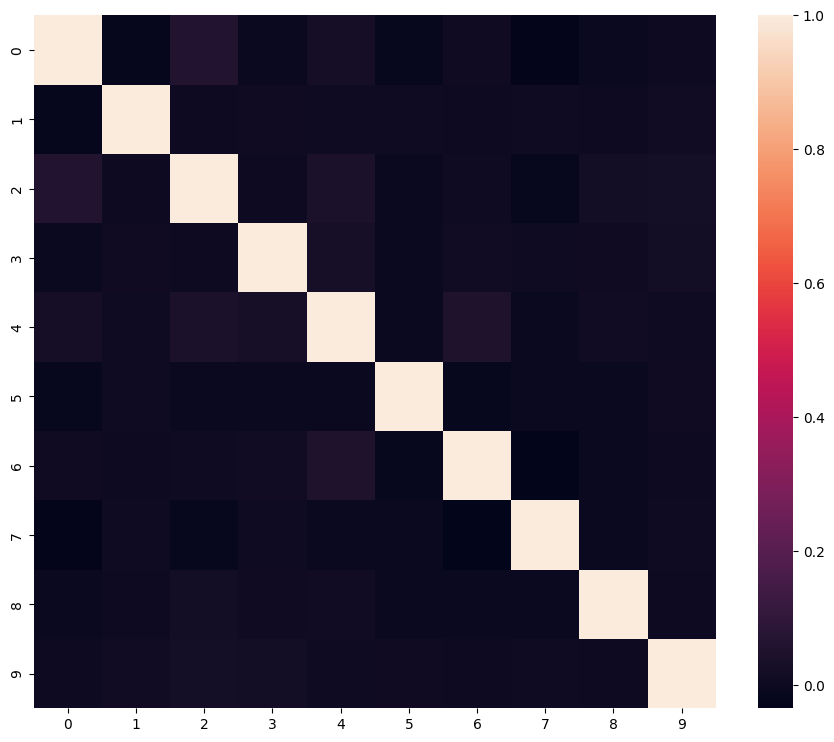

In [27]:
# validation results
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import palettable

plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=corr_mean,
           )

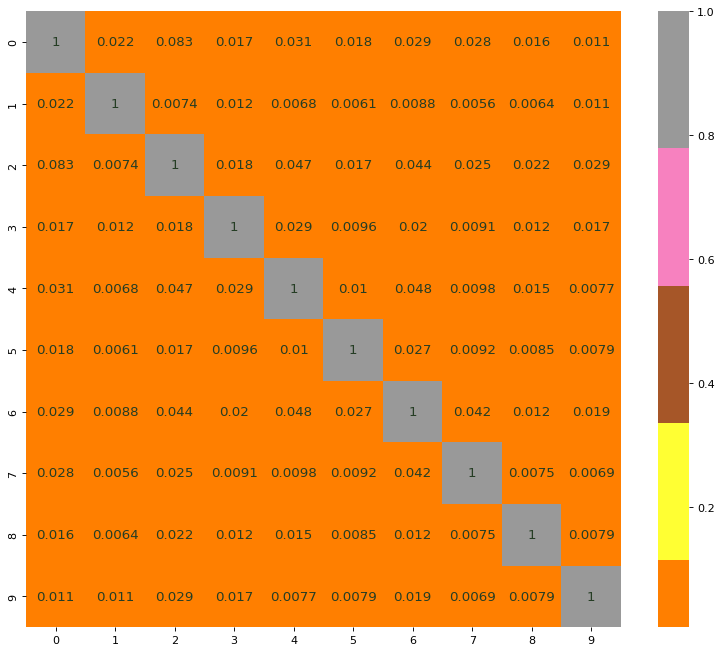

In [28]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_abs_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [29]:
np.sum(corr_abs_mean)-10

1.7085689520463347

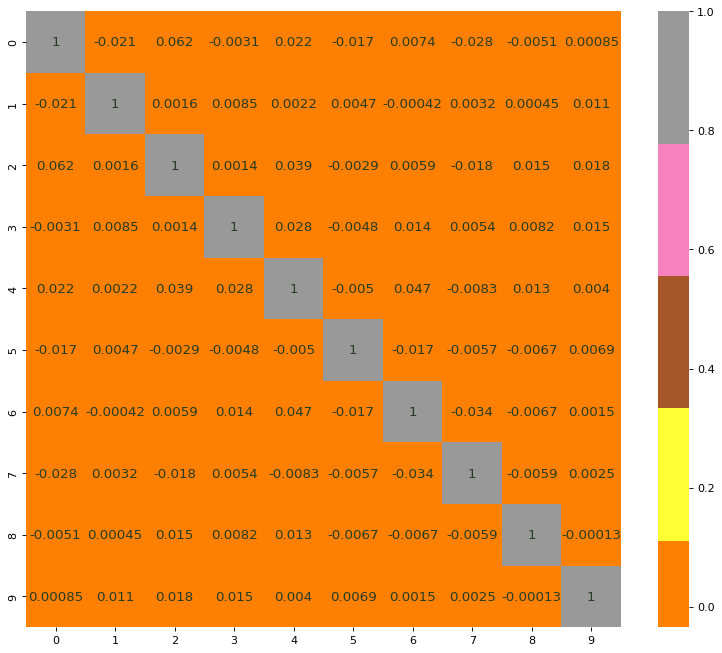

In [30]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

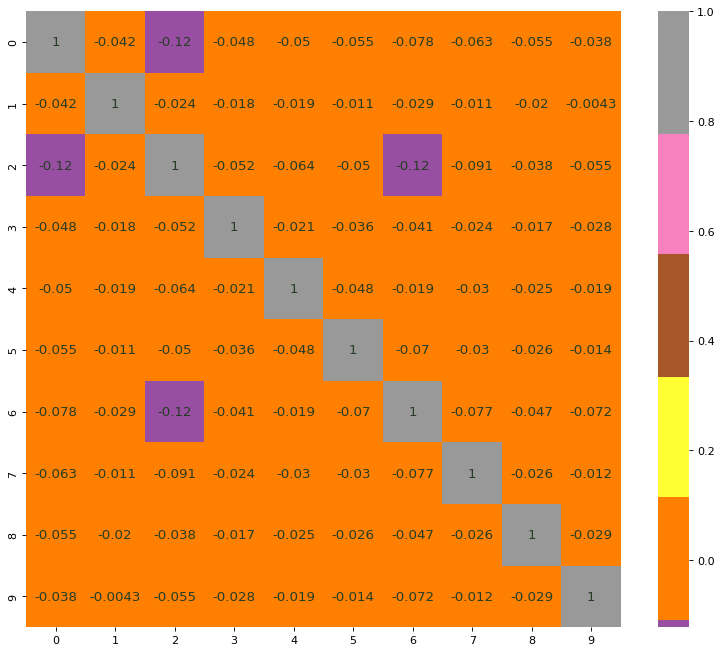

In [31]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_min,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

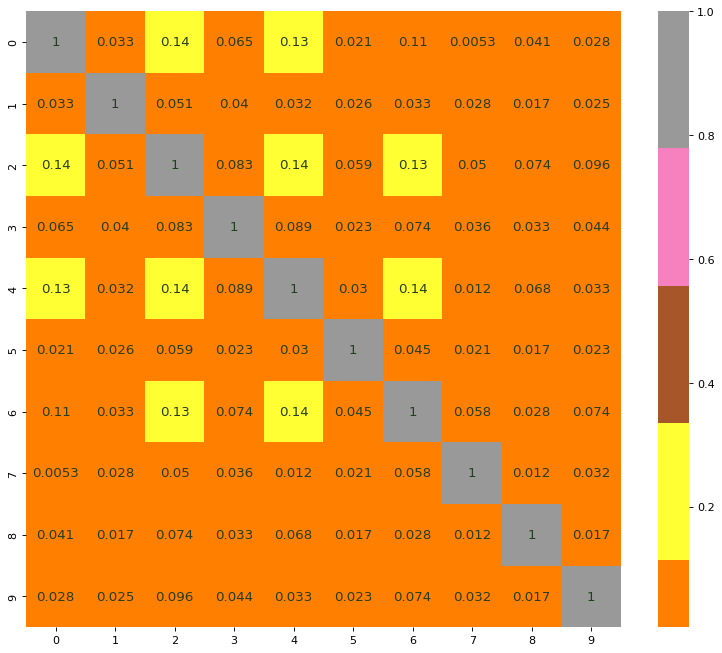

In [32]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_max,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [33]:
np.save('FMNIST-normal-acc-label'+str(LABEL)+'-repeat.npy',acc_record)
np.save('FMNIST-normal-radius-label'+str(LABEL)+'-repeat.npy',r_records)
np.save('FMNIST-normal-corr-label'+str(LABEL)+'-repeat.npy',corr_whole)
# only need to save because we only train netD
torch.save(netD, 'Final_FMNIST_normal_NetD-label'+str(LABEL)+'-repeat.pth')
#torch.save(netV, 'MNIST_NetV-mode1-radius2-makeup.pth')
#torch.save(netG, 'MNIST_NetG-mode1-radius2-makeup.pth')

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.24009999999999998
SVD: 0.1805
NetG_fixDwith radius 99.90221409224006 0.2225
99.90221409224006 0.2225
51.62309467792511 53.492899954319 -21.194937635213137 85.74954056739807


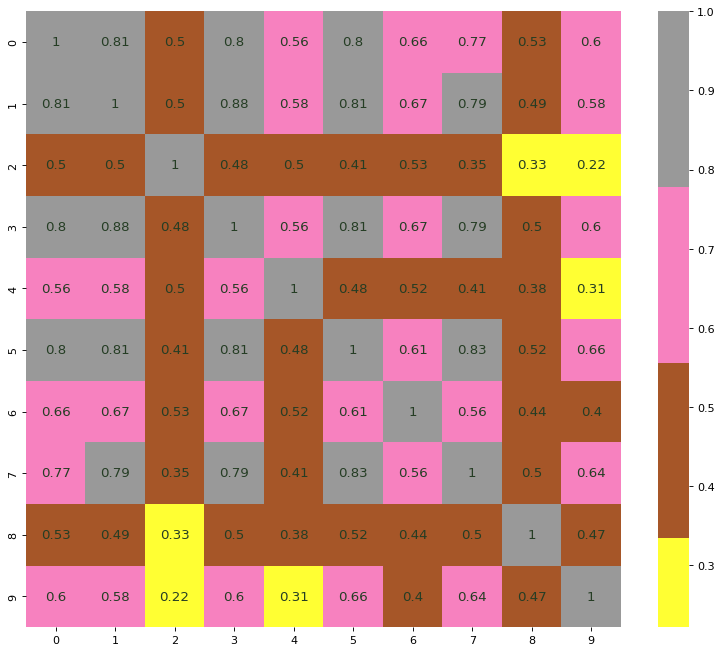

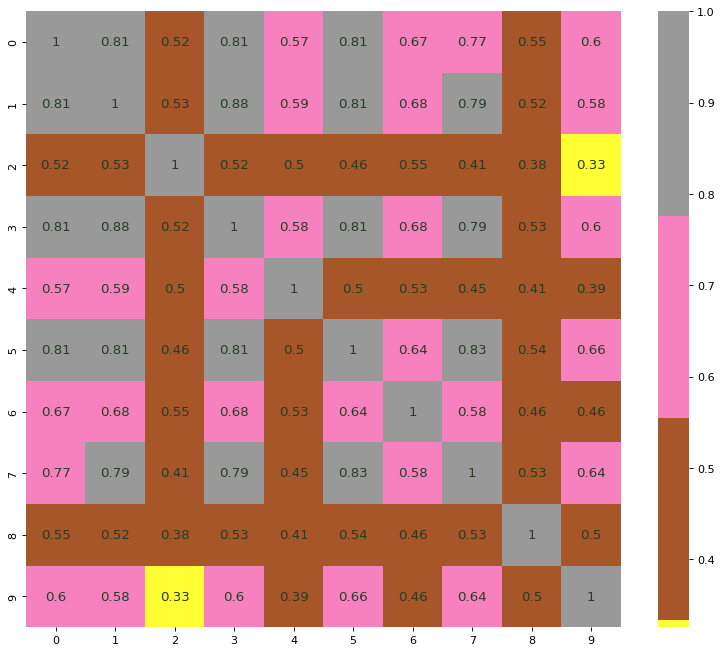

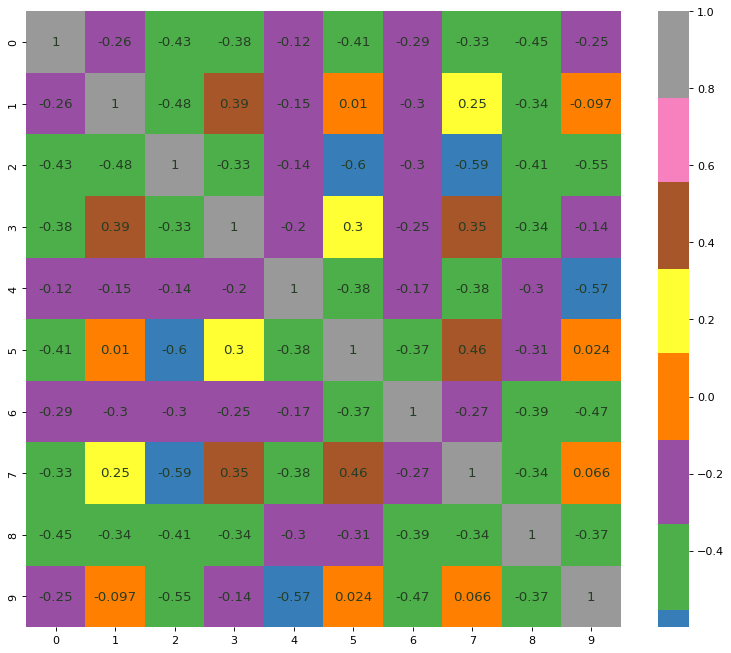

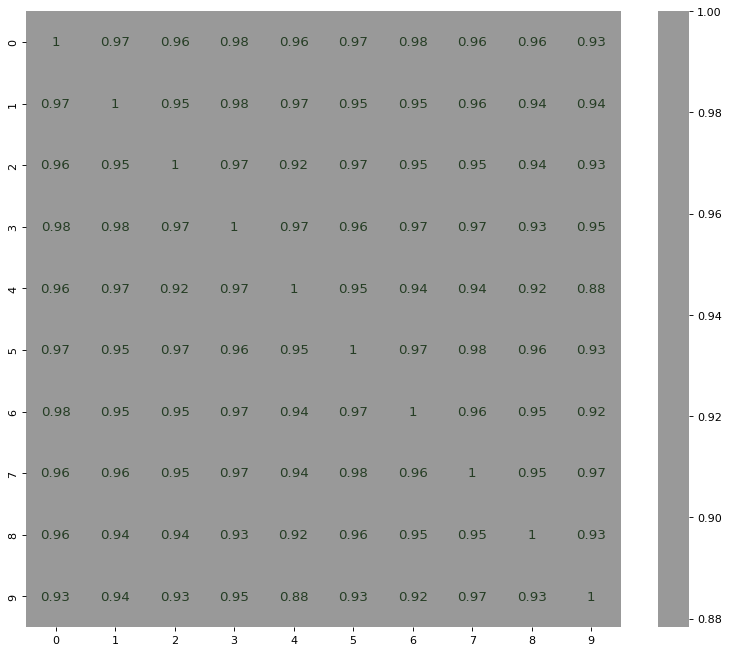

In [34]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.30269999999999997
SVD: 0.2027
NetG_fixDwith radius 35.6832687654794 0.0704
35.6832687654794 0.0704
49.35352298617363 49.776743054389954 -2.8411348909139633 83.4774854183197


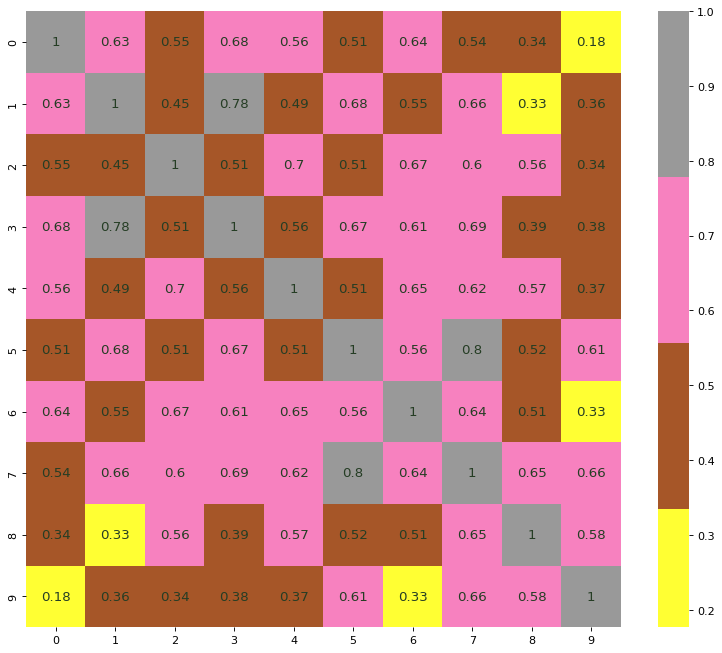

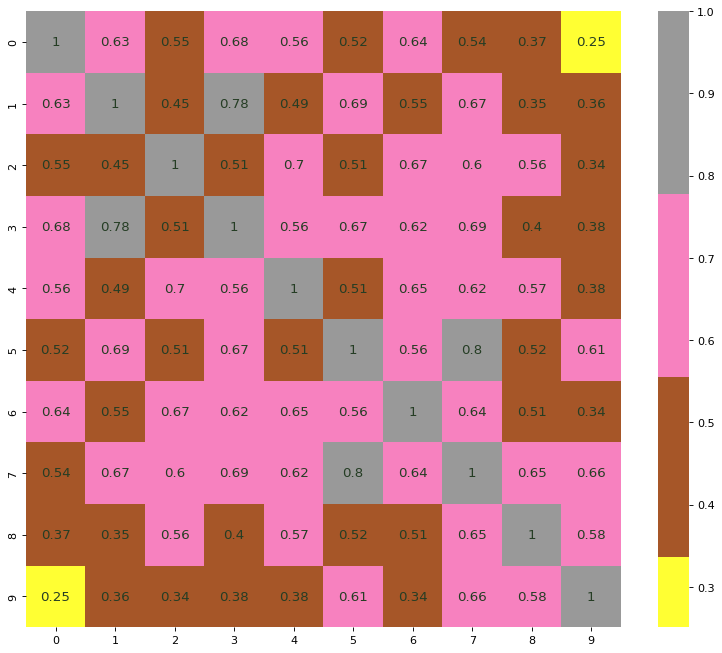

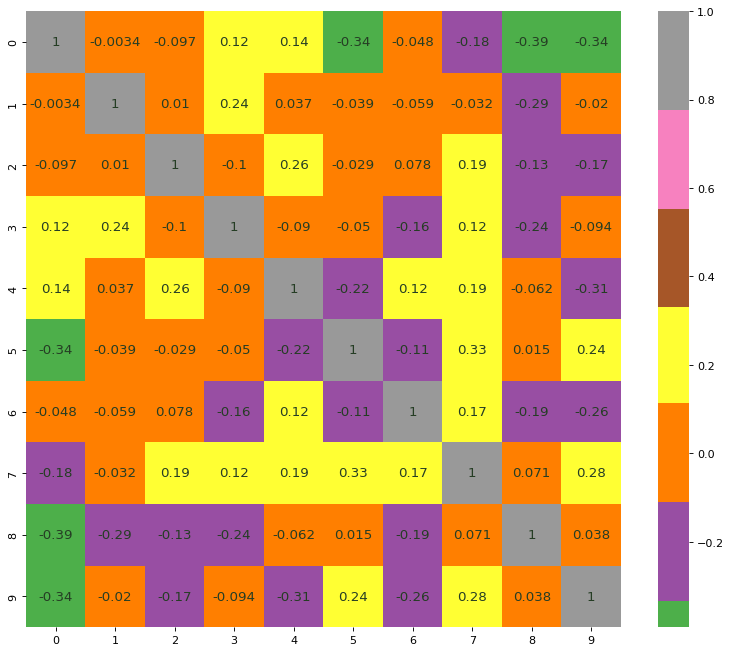

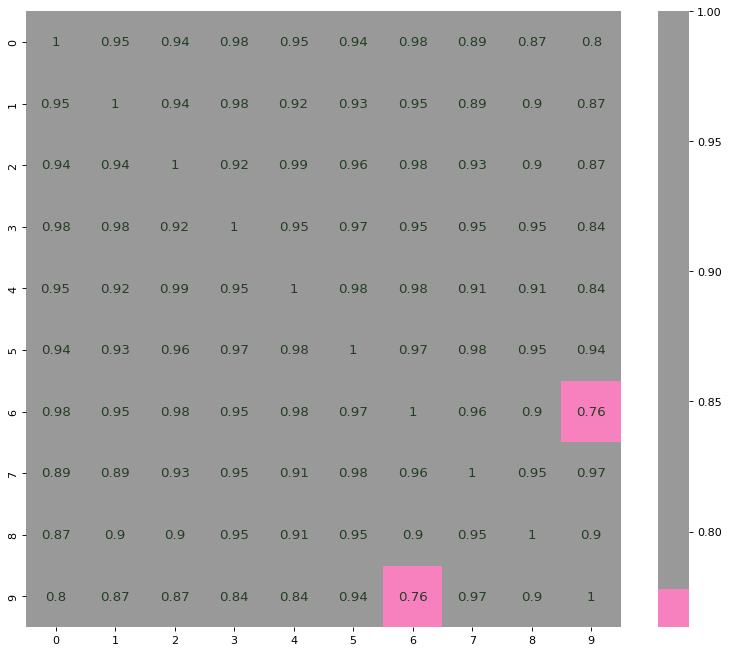

In [35]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.42300000000000004
SVD: 0.2793
NetG_fixDwith radius 0.02196255859143295 0.8204
0.02196255859143295 0.8204
-0.26478901294467505 1.6762658664956689 -4.668104264885187 3.9221120961010456


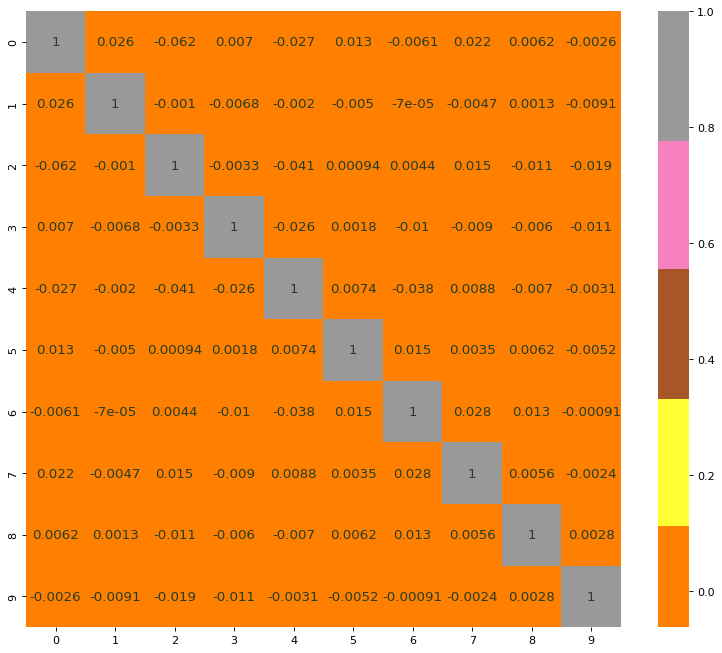

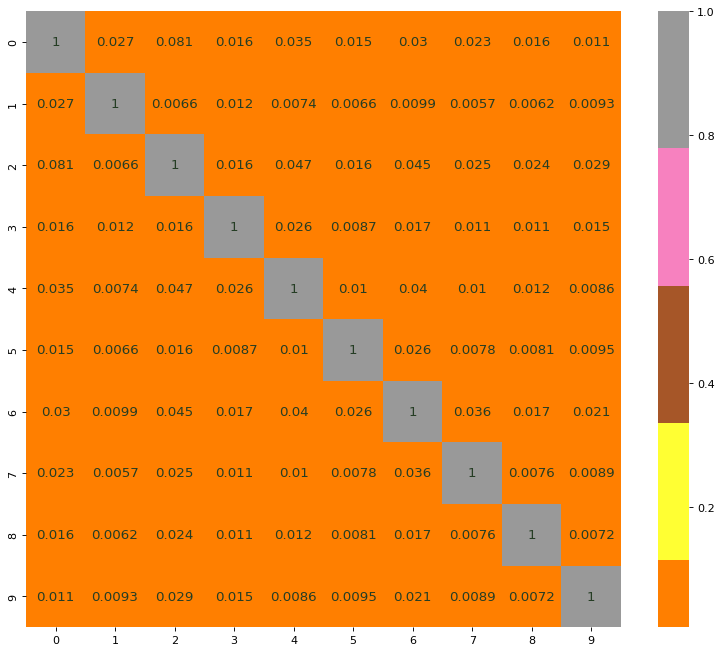

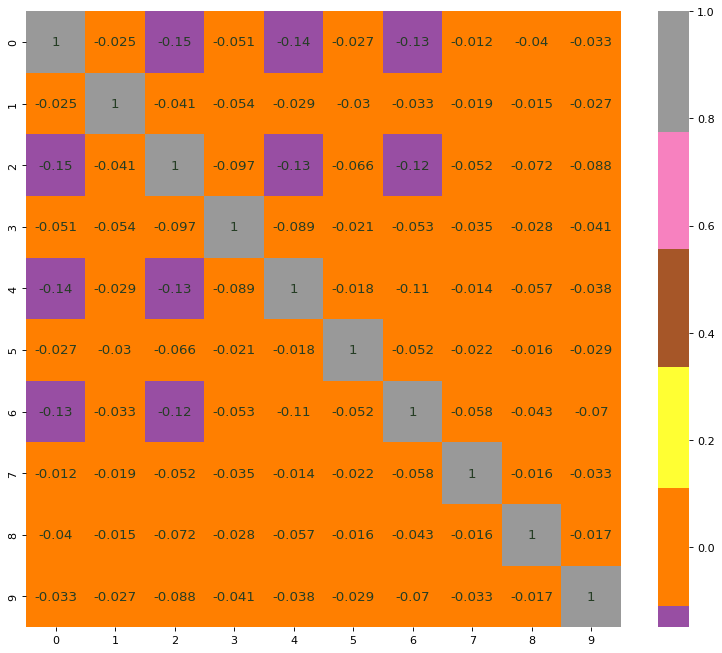

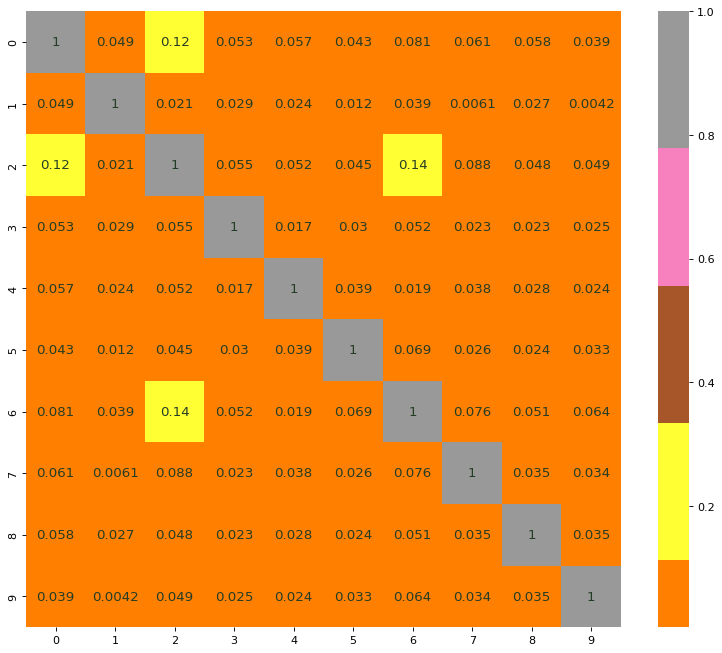

In [36]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.2298
SVD: 0.18769999999999998
NetG_fixDwith radius 12.457255374193313 0.124
12.457255374193313 0.124
48.79936456680298 49.277864158153534 -8.784796938300133 82.73048758506775


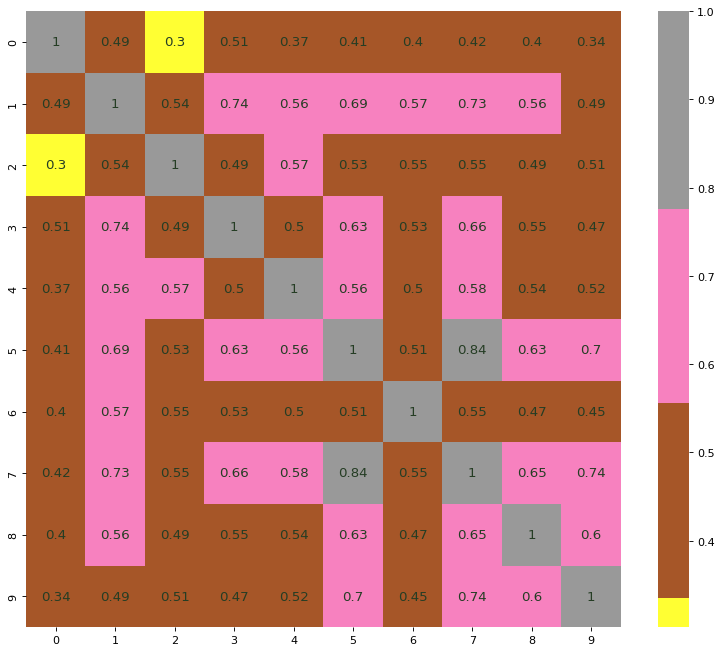

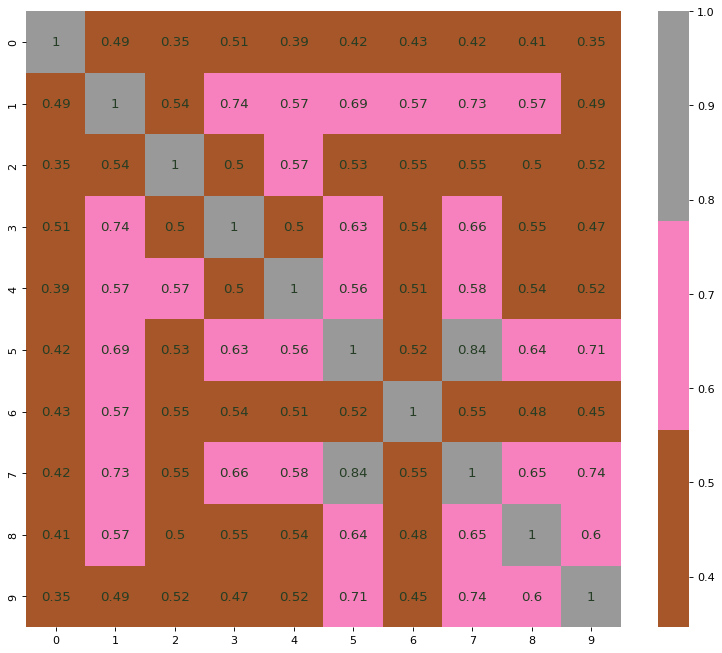

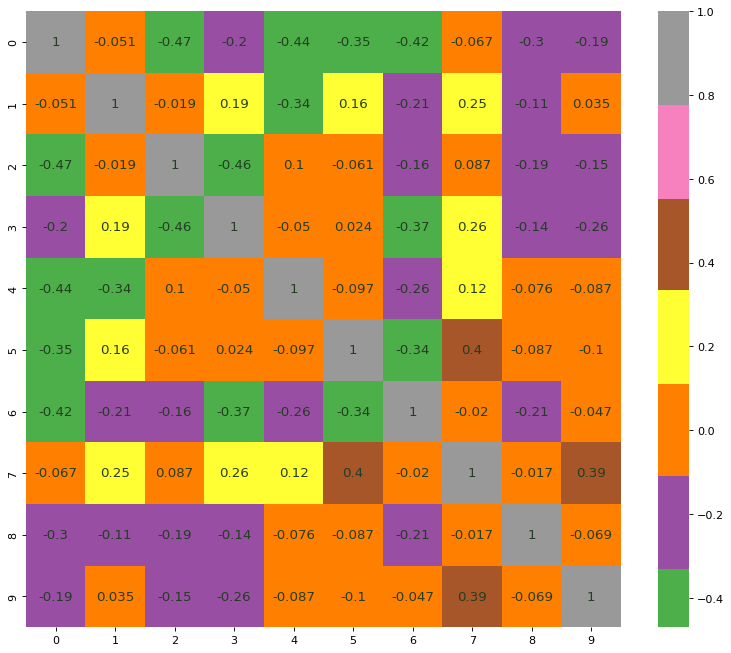

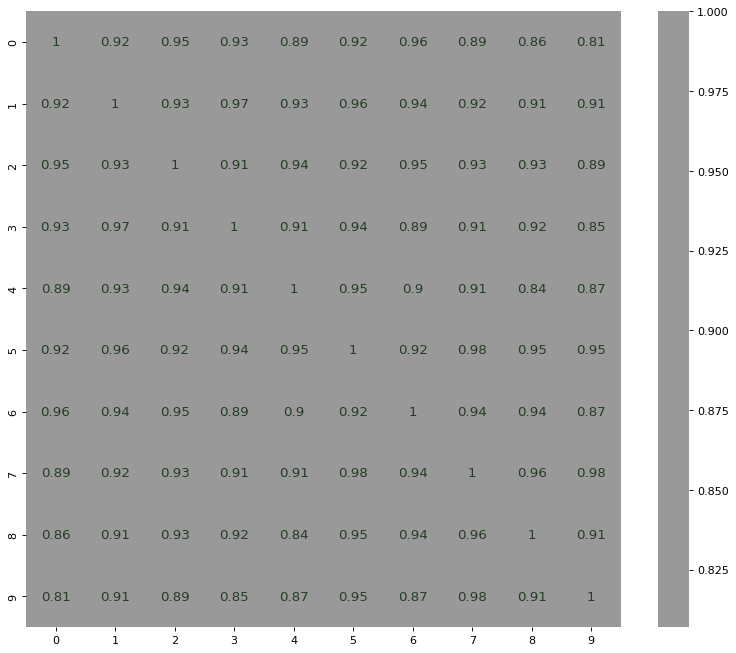

In [37]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.23729999999999996
SVD: 0.1825
NetG_fixDwith radius 79.88554608989783 0.0884
79.88554608989783 0.0884
52.14897567033768 52.26281672716141 -0.8319232389330864 83.53593122959137


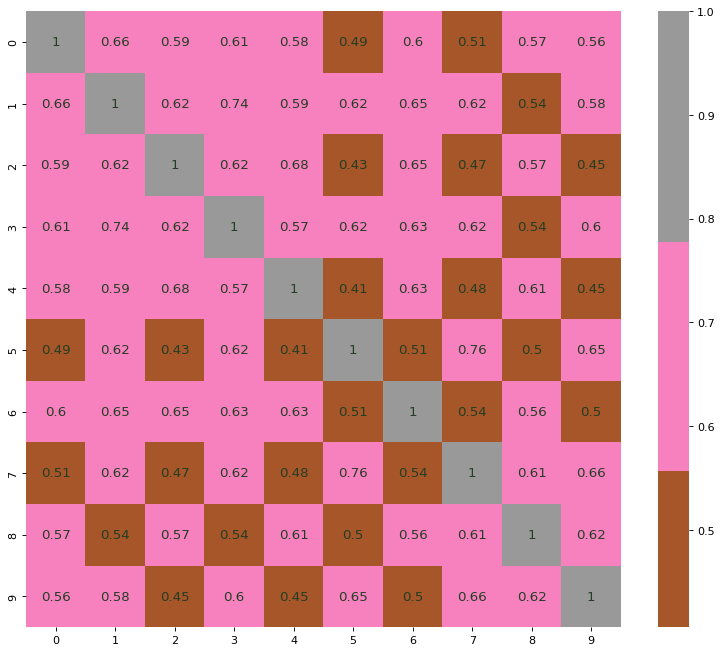

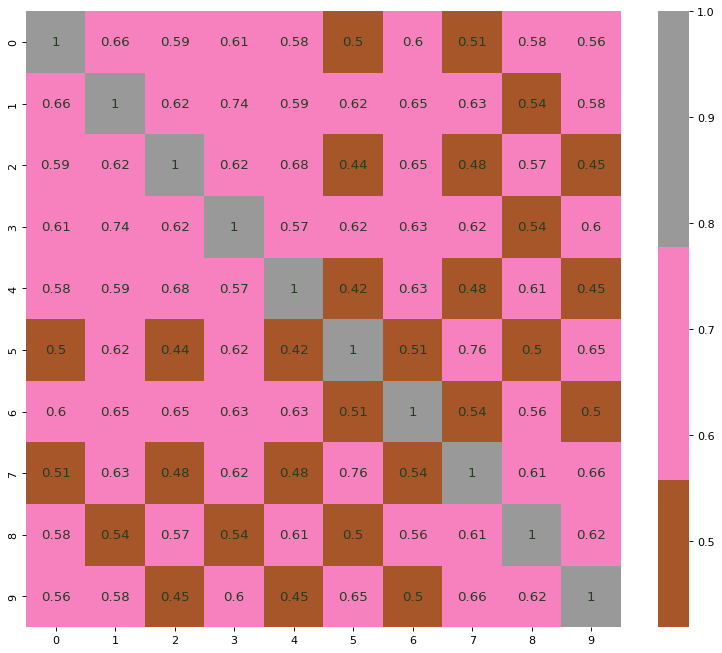

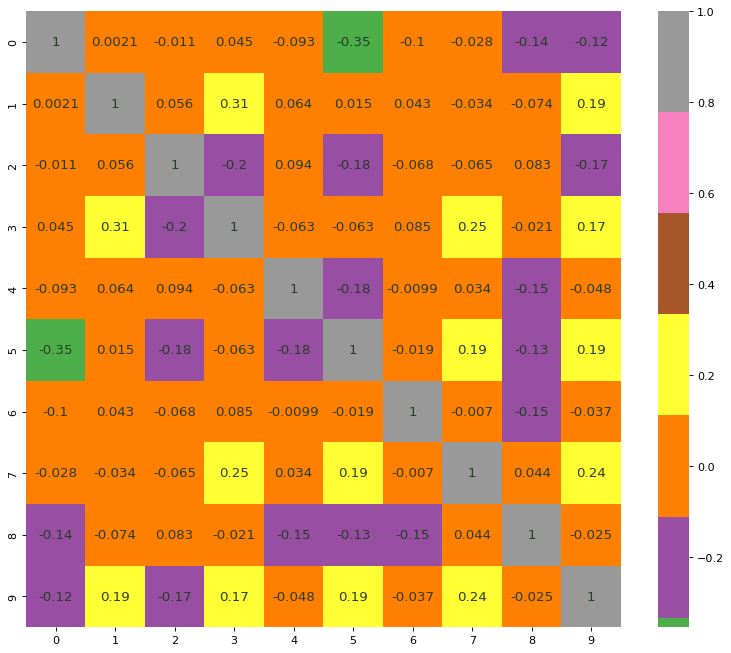

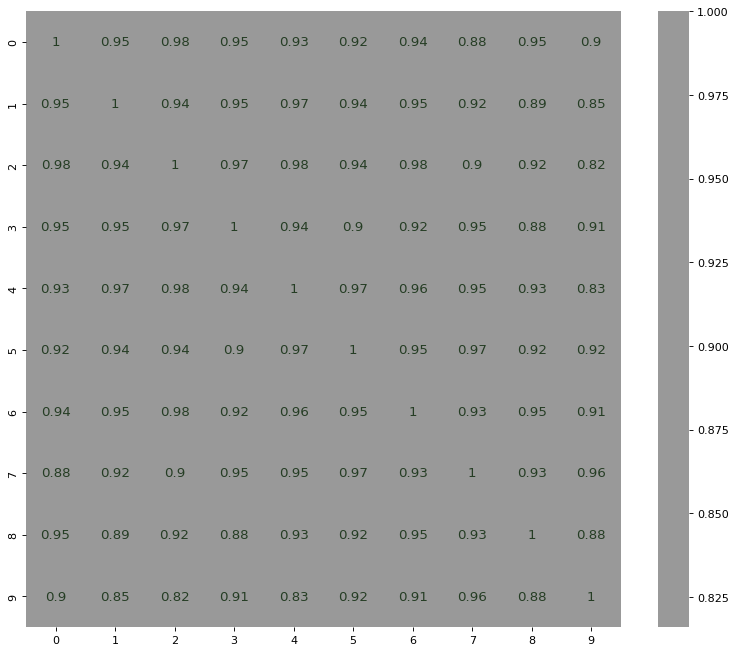

In [38]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.2761
SVD: 0.18059999999999998
NetG_fixDwith radius 9.433482290676457 0.2267
9.433482290676457 0.2267
33.7612479776144 36.55399715900421 -31.473569303750992 77.73131537437439


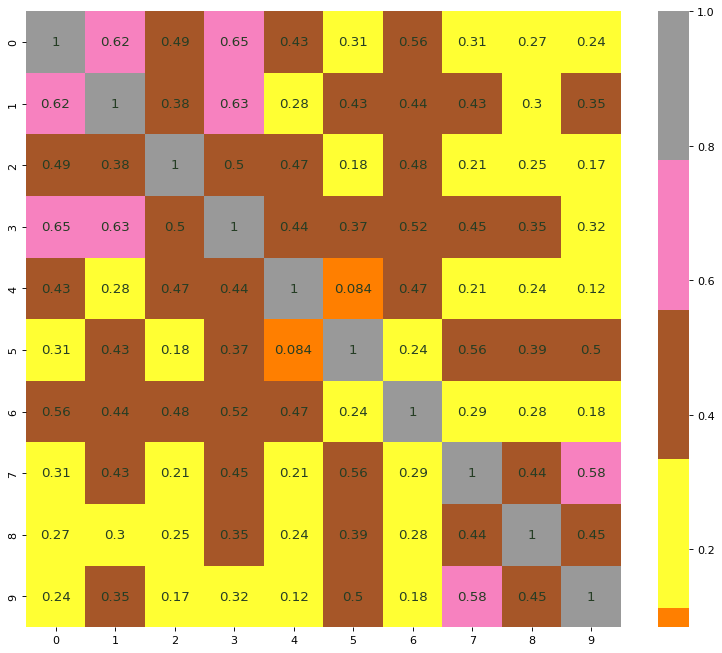

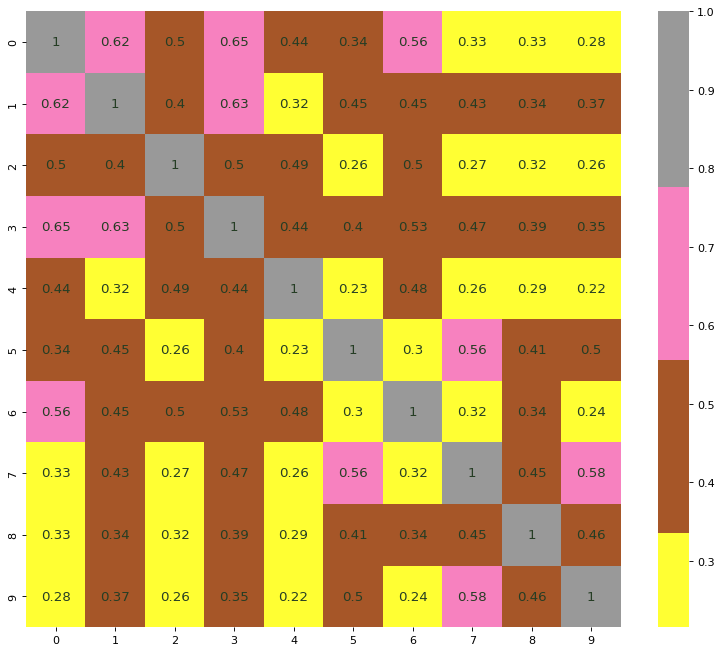

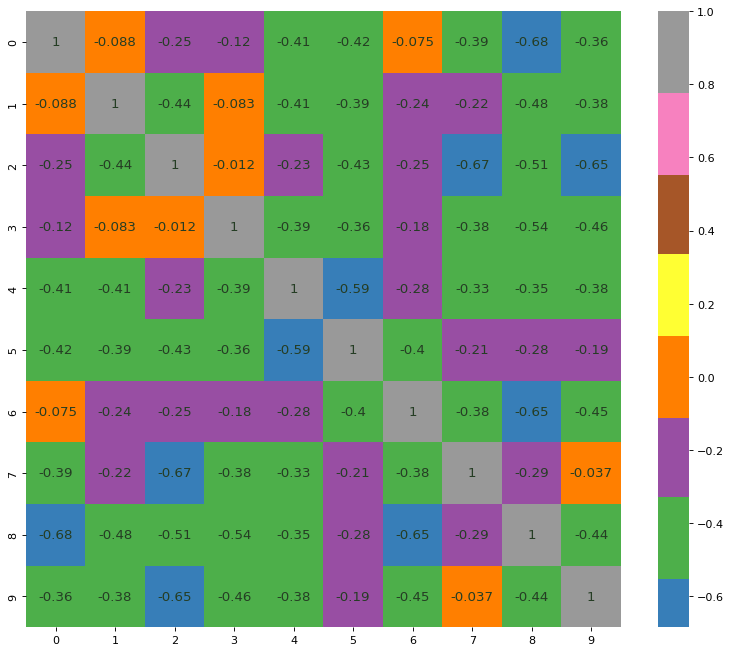

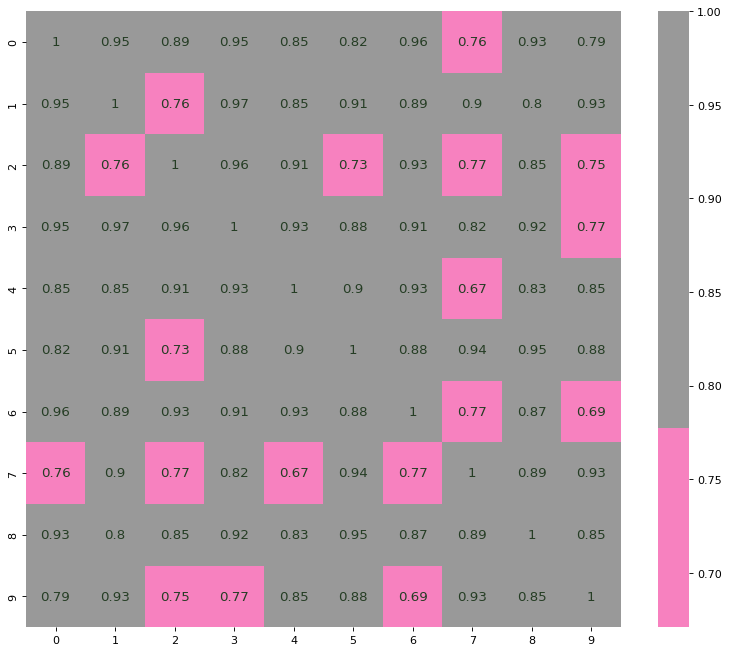

In [39]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.25760000000000005
SVD: 0.18889999999999996
NetG_fixDwith radius 99.99499629876415 0.1216
99.99499629876415 0.1216
56.06370961666107 56.13296550512314 4.821395371109247 82.81496572494507


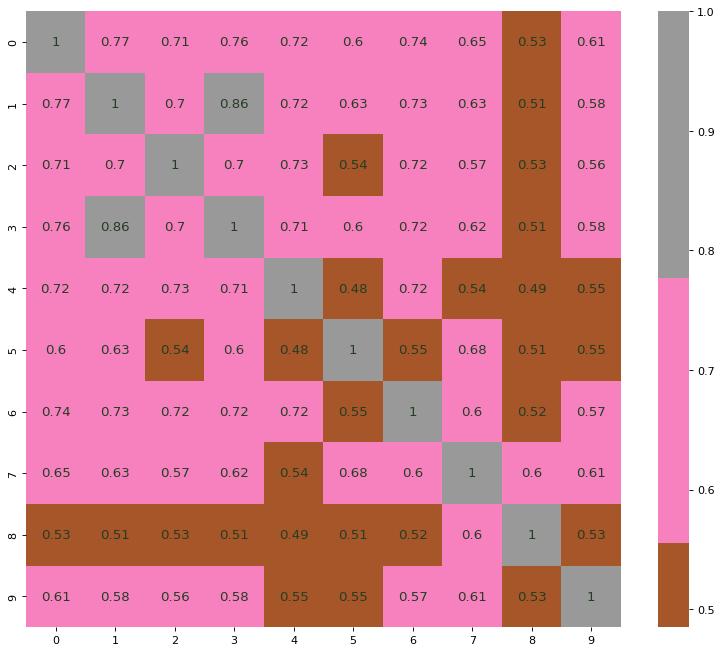

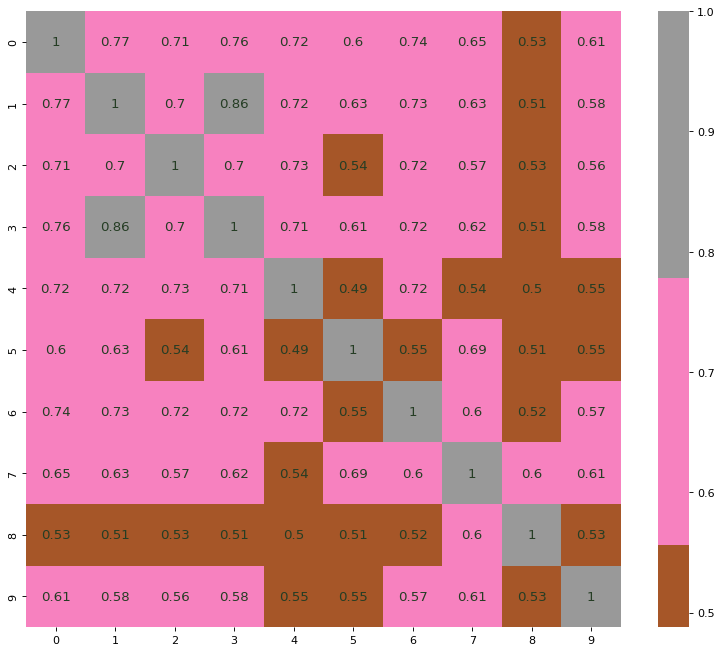

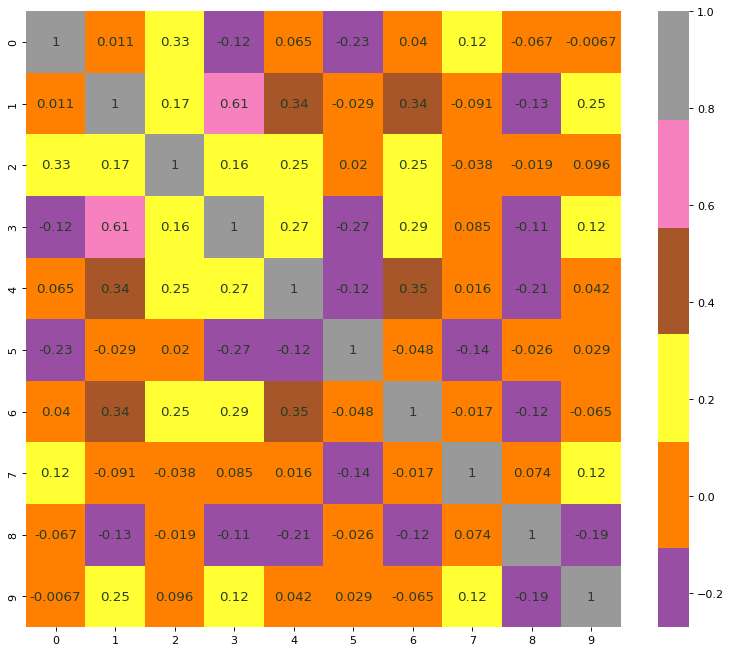

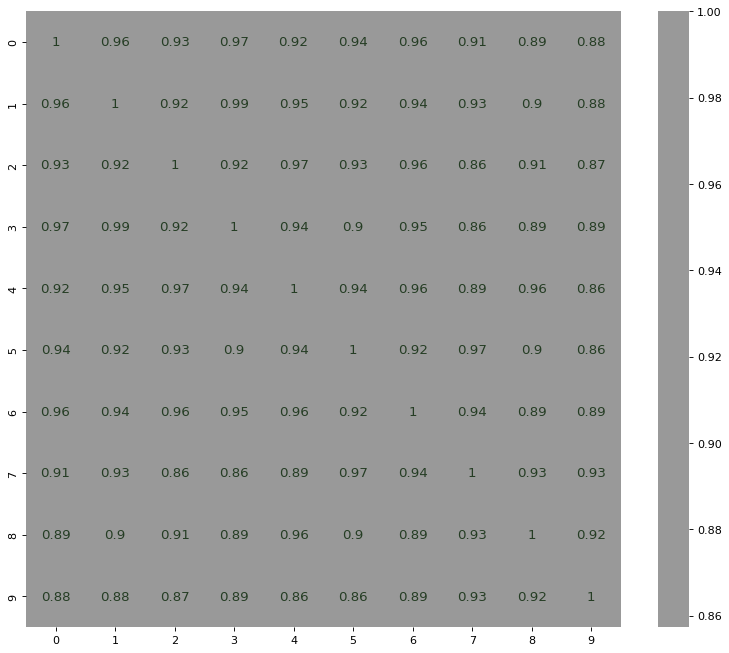

In [40]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


----------------------------
Train_z, Test_z
PCA: 0.42510000000000003
SVD: 0.277
NetG_fixDwith radius 0.001277645543126003 0.8196
0.001277645543126003 0.8196
-0.26002857234561816 1.680561177432537 -4.679554753005505 3.889842167496681


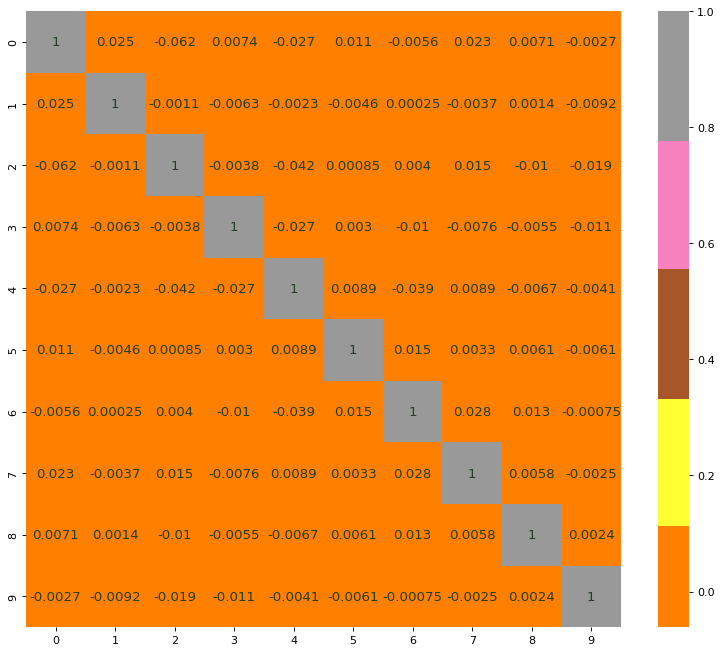

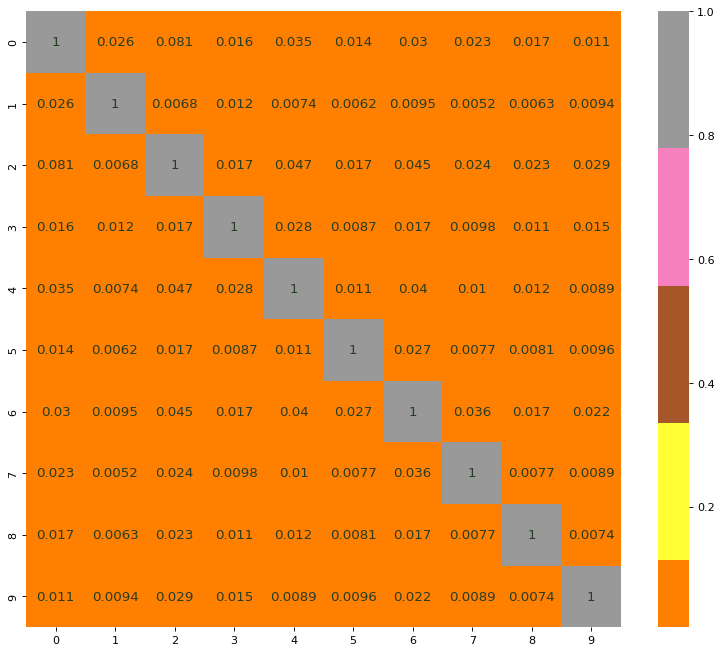

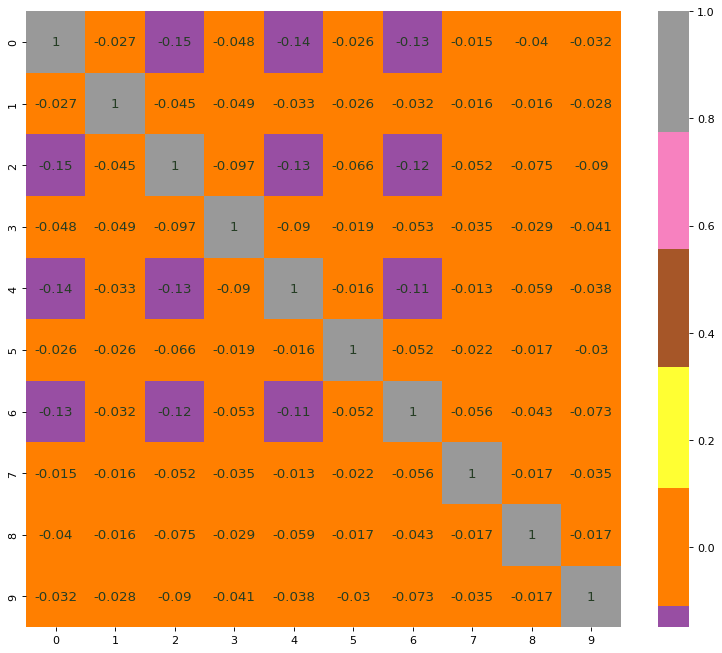

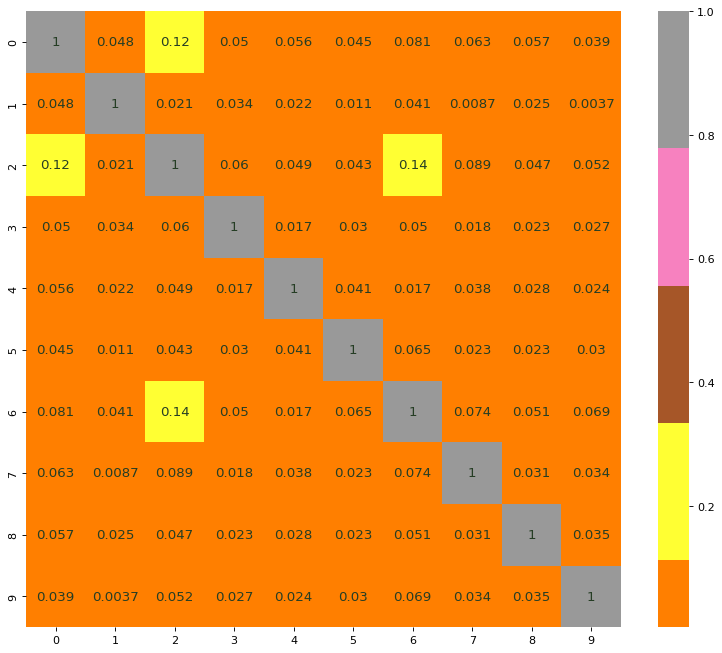

In [41]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.42490000000000006
SVD: 0.2772
NetG_fixDwith radius 0.0010960902078360666 0.8198
0.0010960902078360666 0.8198
-0.2593827409436926 1.6804702607914805 -4.679161868989468 3.89094615355134


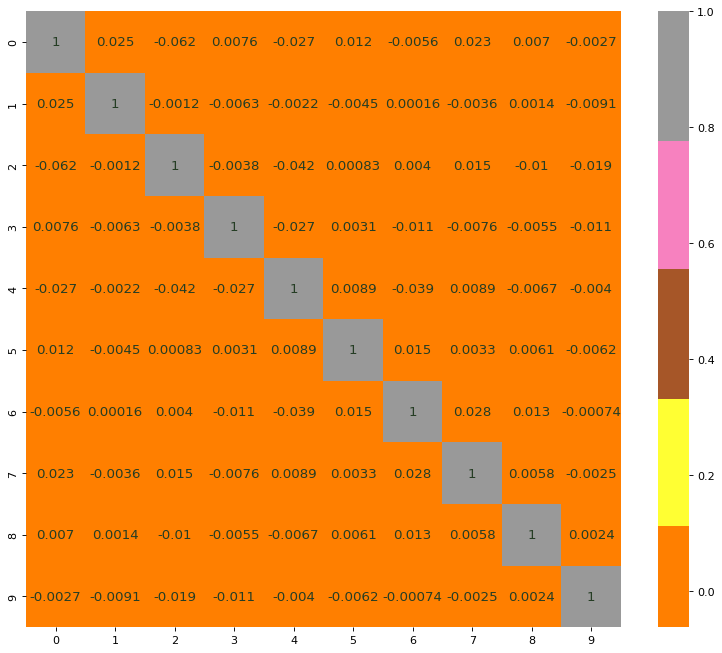

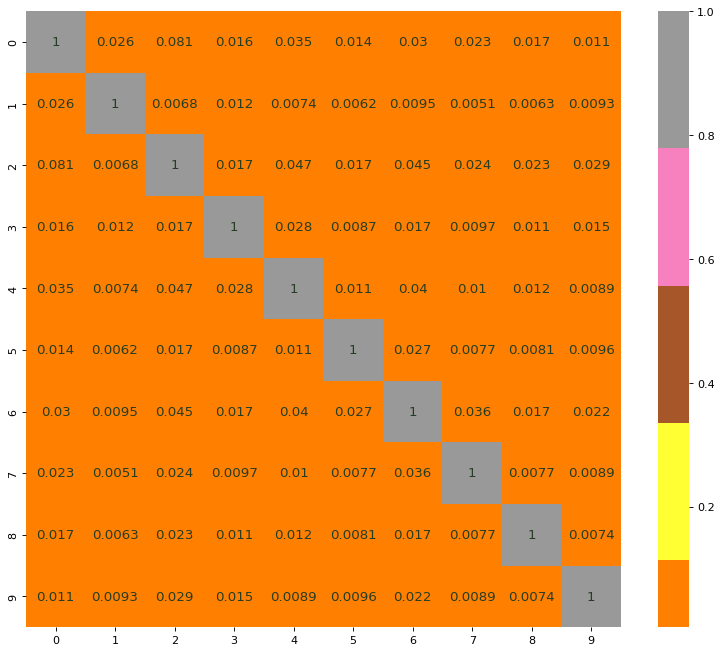

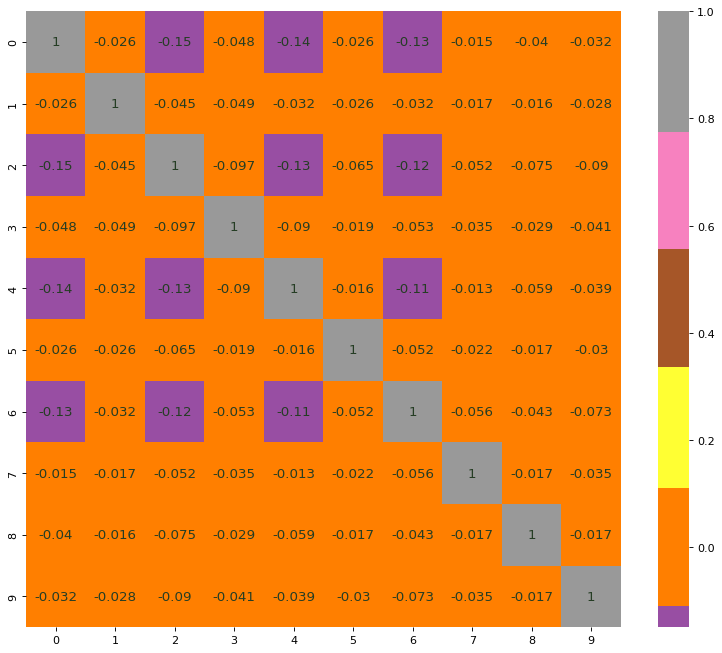

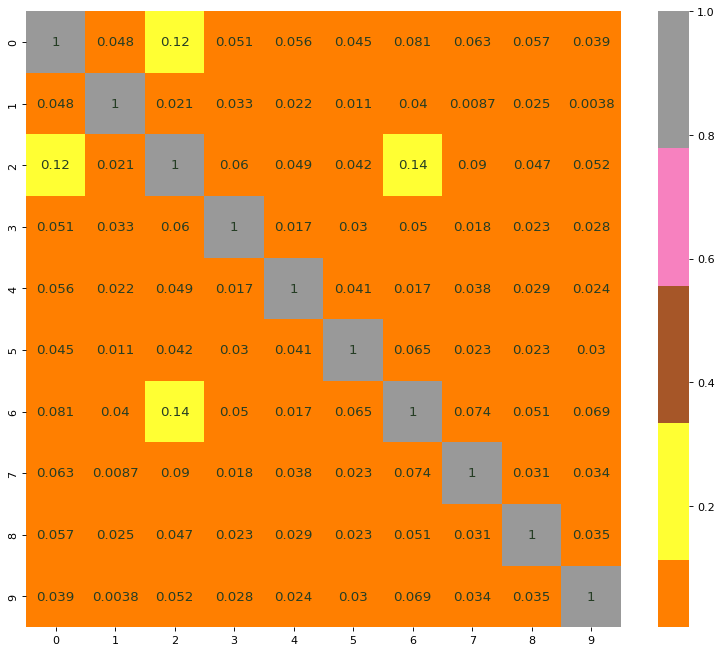

In [42]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



In [43]:
acc_record

array([[8.38100000e-01, 8.20220000e-01, 8.20220000e-01, 8.21510000e-01,
        8.19935000e-01, 8.10285000e-01, 6.77335000e-01, 4.29395000e-01,
        1.55660000e-01, 1.16425000e-01, 9.19800000e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.38100000e-01, 8.21800000e-01, 8.21900000e-01, 8.23900000e-01,
        8.23400000e-01, 8.17500000e-01, 7.91400000e-01, 6.33600000e-01,
        3.03300000e-01, 2.58400000e-01, 2.16000000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.38100000e-01, 8.18100000e-01, 8.17600000e-01, 8.18900000e-01,
        8.17500000e-01, 8.00900000e-01, 4.04100000e-01, 2.59400000e-01,
        9.70000000e-02, 2.08000000e-02, 2.93000000e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000